In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import itertools
import networkx as nx

In [2]:
from numba import jit

In [3]:
import importlib
import evotsc
import evotsc_lib
import evotsc_plot
importlib.reload(evotsc)
importlib.reload(evotsc_lib)
importlib.reload(evotsc_plot)

<module 'evotsc_plot' from '/Users/theotime/Work/Code/EvoTSC/evotsc_plot.py'>

In [4]:
label_fontsize=20
tick_fontsize=15
legend_fontsize=15
dpi=300

In [5]:
control_path = pathlib.Path('/Users/theotime/Desktop/evotsc/phd/continuous-epistasis/wt-control/')
sc_path = pathlib.Path('/Users/theotime/Desktop/evotsc/phd/continuous-epistasis/wt-with-sc/')

gen = 1_000_000

orient_name = ['leading', 'lagging'] # Name of each gene orientation
rel_orients = ['conv', 'div', 'downstr', 'upstr'] # In alphabetical order

In [6]:
rng = np.random.default_rng(seed=123456)

In [7]:
control_rep_dirs = sorted([d for d in control_path.iterdir() if (d.is_dir() and d.name.startswith("rep"))])
sc_rep_dirs = sorted([d for d in sc_path.iterdir() if (d.is_dir() and d.name.startswith("rep"))])

control_params = evotsc_lib.read_params(control_rep_dirs[0])
sc_params = evotsc_lib.read_params(sc_rep_dirs[0])

In [8]:
sc_params

{'commit': '6205422-dirty',
 'seed': 957328076.0,
 'neutral': False,
 'nb_indivs': 100.0,
 'nb_genes': 60.0,
 'intergene': 125.0,
 'gene_length': 1000.0,
 'interaction_dist': 5000.0,
 'interaction_coef': 0.03,
 'sigma_basal': -0.066,
 'sigma_opt': -0.042,
 'epsilon': 0.005,
 'm': 2.5,
 'default_basal_expression': 0.5410424993119494,
 'selection_coef': 250.0,
 'selection_method': 'fit-prop',
 'sigma_env': 0.0,
 'inversion_poisson_lam': 2.0,
 'intergene_poisson_lam': 0.0,
 'intergene_mutation_var': 0.0,
 'basal_sc_mutation_prob': 0.1,
 'basal_sc_mutation_var': 0.0001,
 'save_step': 50000.0}

# Make random individuals (reused throughout)

In [9]:
def make_random_indivs(nb_indiv, params):
    
    mutation = evotsc.Mutation(inversion_poisson_lam=params['inversion_poisson_lam'])
    
    rand_indivs = []
    
    for rep in range(nb_indiv):
        indiv = evotsc_lib.make_random_indiv(intergene=int(params['intergene']),
                                             gene_length=int(params['gene_length']),
                                             nb_genes=int(params['nb_genes']),
                                             default_basal_expression=params['default_basal_expression'],
                                             interaction_dist=params['interaction_dist'],
                                             interaction_coef=params['interaction_coef'],
                                             sigma_basal=params['sigma_basal'],
                                             sigma_opt=params['sigma_opt'],
                                             epsilon=params['epsilon'],
                                             m=params['m'],
                                             selection_coef=params['selection_coef'],
                                             mutation=mutation,
                                             rng=rng,
                                             nb_mutations=100)
        
        indiv.inter_matrix = indiv.compute_inter_matrix()

        rand_indivs.append(indiv)
        
    return rand_indivs

In [10]:
rand_indivs = make_random_indivs(nb_indiv=30, params=control_params)

# Evolutionary stats

In [11]:
def get_stats(exp_name, params):
    
    exp_name = pathlib.Path(exp_name)
        
    rep_dirs = sorted([d for d in exp_name.iterdir() if (d.is_dir() and d.name.startswith("rep"))])
    
    res = pd.DataFrame()
    
    cols = ['Gen', 'Fitness']
    
    if not(params['intergene_poisson_lam'] is None or params['intergene_poisson_lam'] == 0.0):
        cols += ['Genome size']

    if not(params['basal_sc_mutation_prob'] is None or params['basal_sc_mutation_prob'] == 0.0):
        cols += ['Basal SC']
    
    for i_rep, rep_dir in enumerate(rep_dirs):
        
        res_dir = pd.read_csv(rep_dir.joinpath('stats.csv'), usecols=cols)

        res_dir.insert(0, 'Replicate', i_rep)
        
        res = pd.concat([res, res_dir])
    
    res['Log Fitness'] = np.log(res['Fitness'])
    
    return res

In [12]:
control_stats = get_stats(control_path, control_params)

In [13]:
sc_stats = get_stats(sc_path, sc_params)

## Plot fitness over evolutionary time

In [14]:
def plot_fitness(exp_stats, main_stats, exp_path):
    
    all_stats = [main_stats[main_stats["Gen"] > 0][['Gen', 'Log Fitness', 'Fitness']].copy(),
                 exp_stats[exp_stats["Gen"] > 0][['Gen', 'Log Fitness', 'Fitness']].copy()]
    
    name = ['Control', 'SC mutations']
    
    
    colors = mpl.cm.get_cmap('viridis', 2)(range(2)) # Main vs experiment
    
    plt.figure(figsize=(9, 4), dpi=dpi)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(linestyle=':')
    plt.grid(visible=True, which="minor", axis='x', linestyle=':')
    
    plt.xlabel('Generation', fontsize=label_fontsize)
    plt.ylabel('Fitness', fontsize=label_fontsize)
    
    plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    for i_exp in range(2):
        
        mean_data = all_stats[i_exp].groupby('Gen').mean().reset_index()
        first_dec = all_stats[i_exp].groupby('Gen').quantile(0.1)
        last_dec = all_stats[i_exp].groupby('Gen').quantile(0.9)
        
        # Average fitness
        plt.plot(mean_data['Gen'],
                 np.exp(mean_data['Log Fitness']),
                 color=colors[i_exp],
                 linewidth=2,
                 label=name[i_exp]) 

        # Quantiles
        plt.plot(mean_data['Gen'],
                 first_dec['Fitness'],
                 color=colors[i_exp],
                 alpha=0.3)

        plt.plot(mean_data['Gen'],
                 last_dec['Fitness'],
                 color=colors[i_exp],
                 alpha=0.3)

    plt.legend(loc='lower right', fontsize=legend_fontsize)
        
    plt.savefig(f'{exp_path}/fitness_all_with_main.pdf', dpi=dpi, bbox_inches='tight')

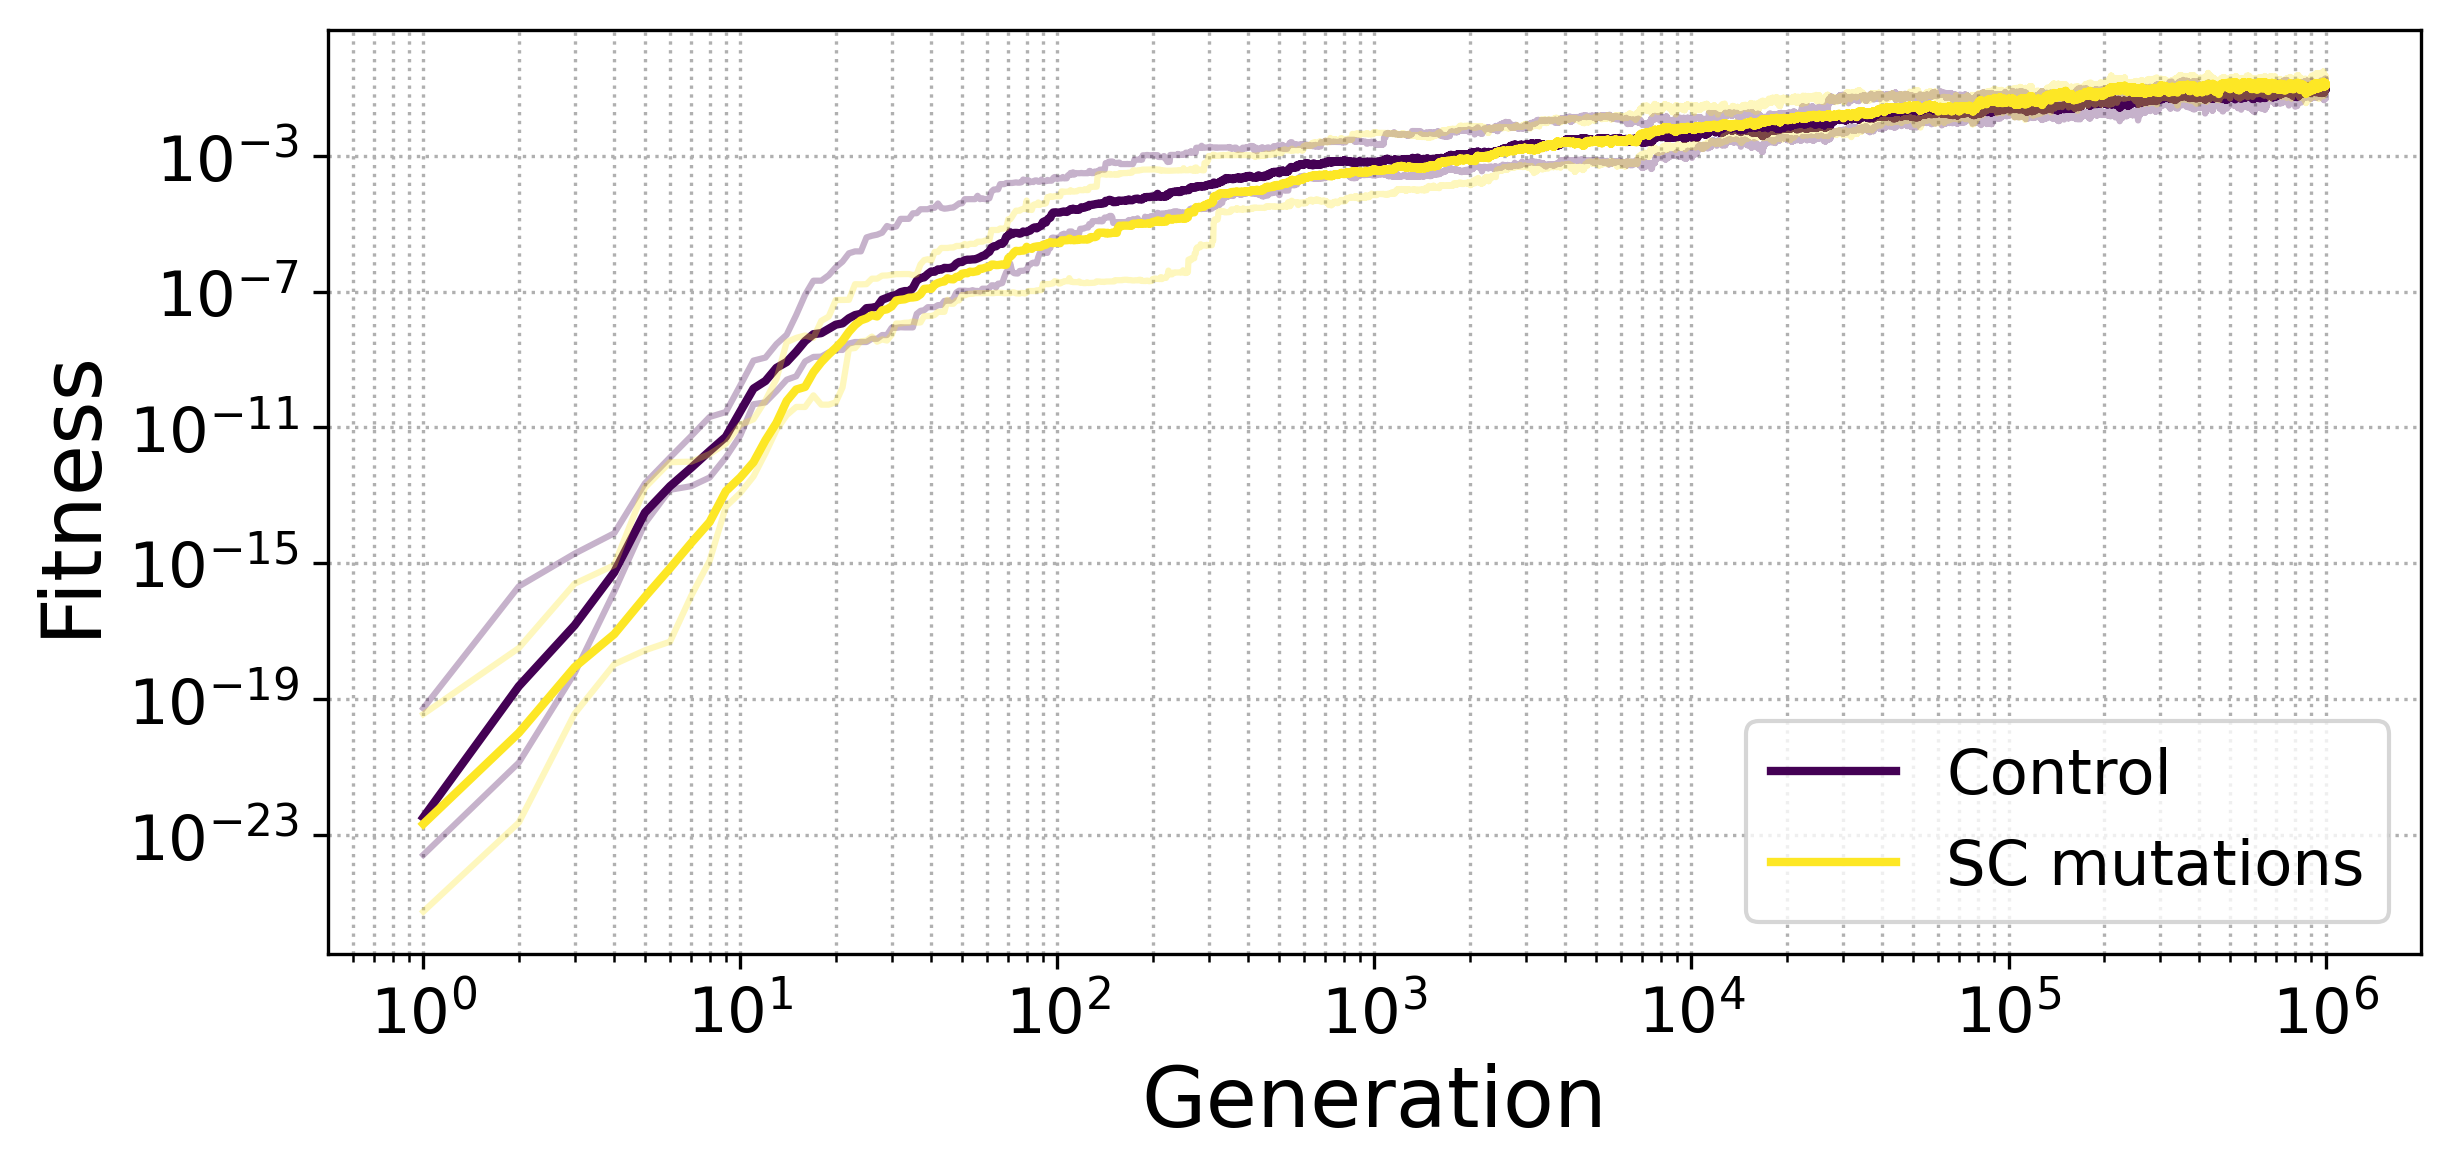

In [15]:
plot_fitness(sc_stats, control_stats, control_path)

In [16]:
def plot_basal_sc(full_stats, exp_path):
    
    max_gen = full_stats.groupby('Replicate').max()['Gen'].min()
    
    stats = full_stats[(full_stats["Gen"] > 0) & (full_stats['Gen'] <= max_gen)][['Gen', 'Basal SC']].copy()
        
    mean_data = stats.groupby('Gen').mean().reset_index()
    
    # Note: for the fitness, the mean can be above the quantile
    first_dec = stats.groupby('Gen').quantile(0.1)
    last_dec = stats.groupby('Gen').quantile(0.9)
    
    colors = mpl.cm.get_cmap('viridis', 2)(range(2)) # Main vs experiment
    
    plt.figure(figsize=(9,4), dpi=dpi)
    
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(linestyle=':')
    plt.grid(visible=True, which="minor", axis='x', linestyle=':')
    
    plt.xlabel('Generation', fontsize=label_fontsize)
    #plt.xlim(-0.05e6, 1.05e6)
    plt.ylabel('Basal SC', fontsize=label_fontsize)
    
    plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        
    # Default value
    plt.plot(mean_data['Gen'],
             np.ones(len(mean_data['Gen'])) * sc_params['sigma_basal'],
             color=colors[0],
             linewidth=2,
             label='Control')
        
    # Average fitness
    plt.plot(mean_data['Gen'],
             mean_data['Basal SC'],
             color=colors[1],
             linewidth=2,
             label='SC mutations') 
    
    # Quantiles
    plt.plot(mean_data['Gen'],
             first_dec['Basal SC'],
             color=colors[1],
             alpha=0.3)
    
    plt.plot(mean_data['Gen'],
             last_dec['Basal SC'],
             color=colors[1],
             alpha=0.3)

    plt.legend(loc='lower right', fontsize=legend_fontsize)
    
    plt.savefig(f'{exp_path}/basal_sc_all.pdf', dpi=dpi, bbox_inches='tight')

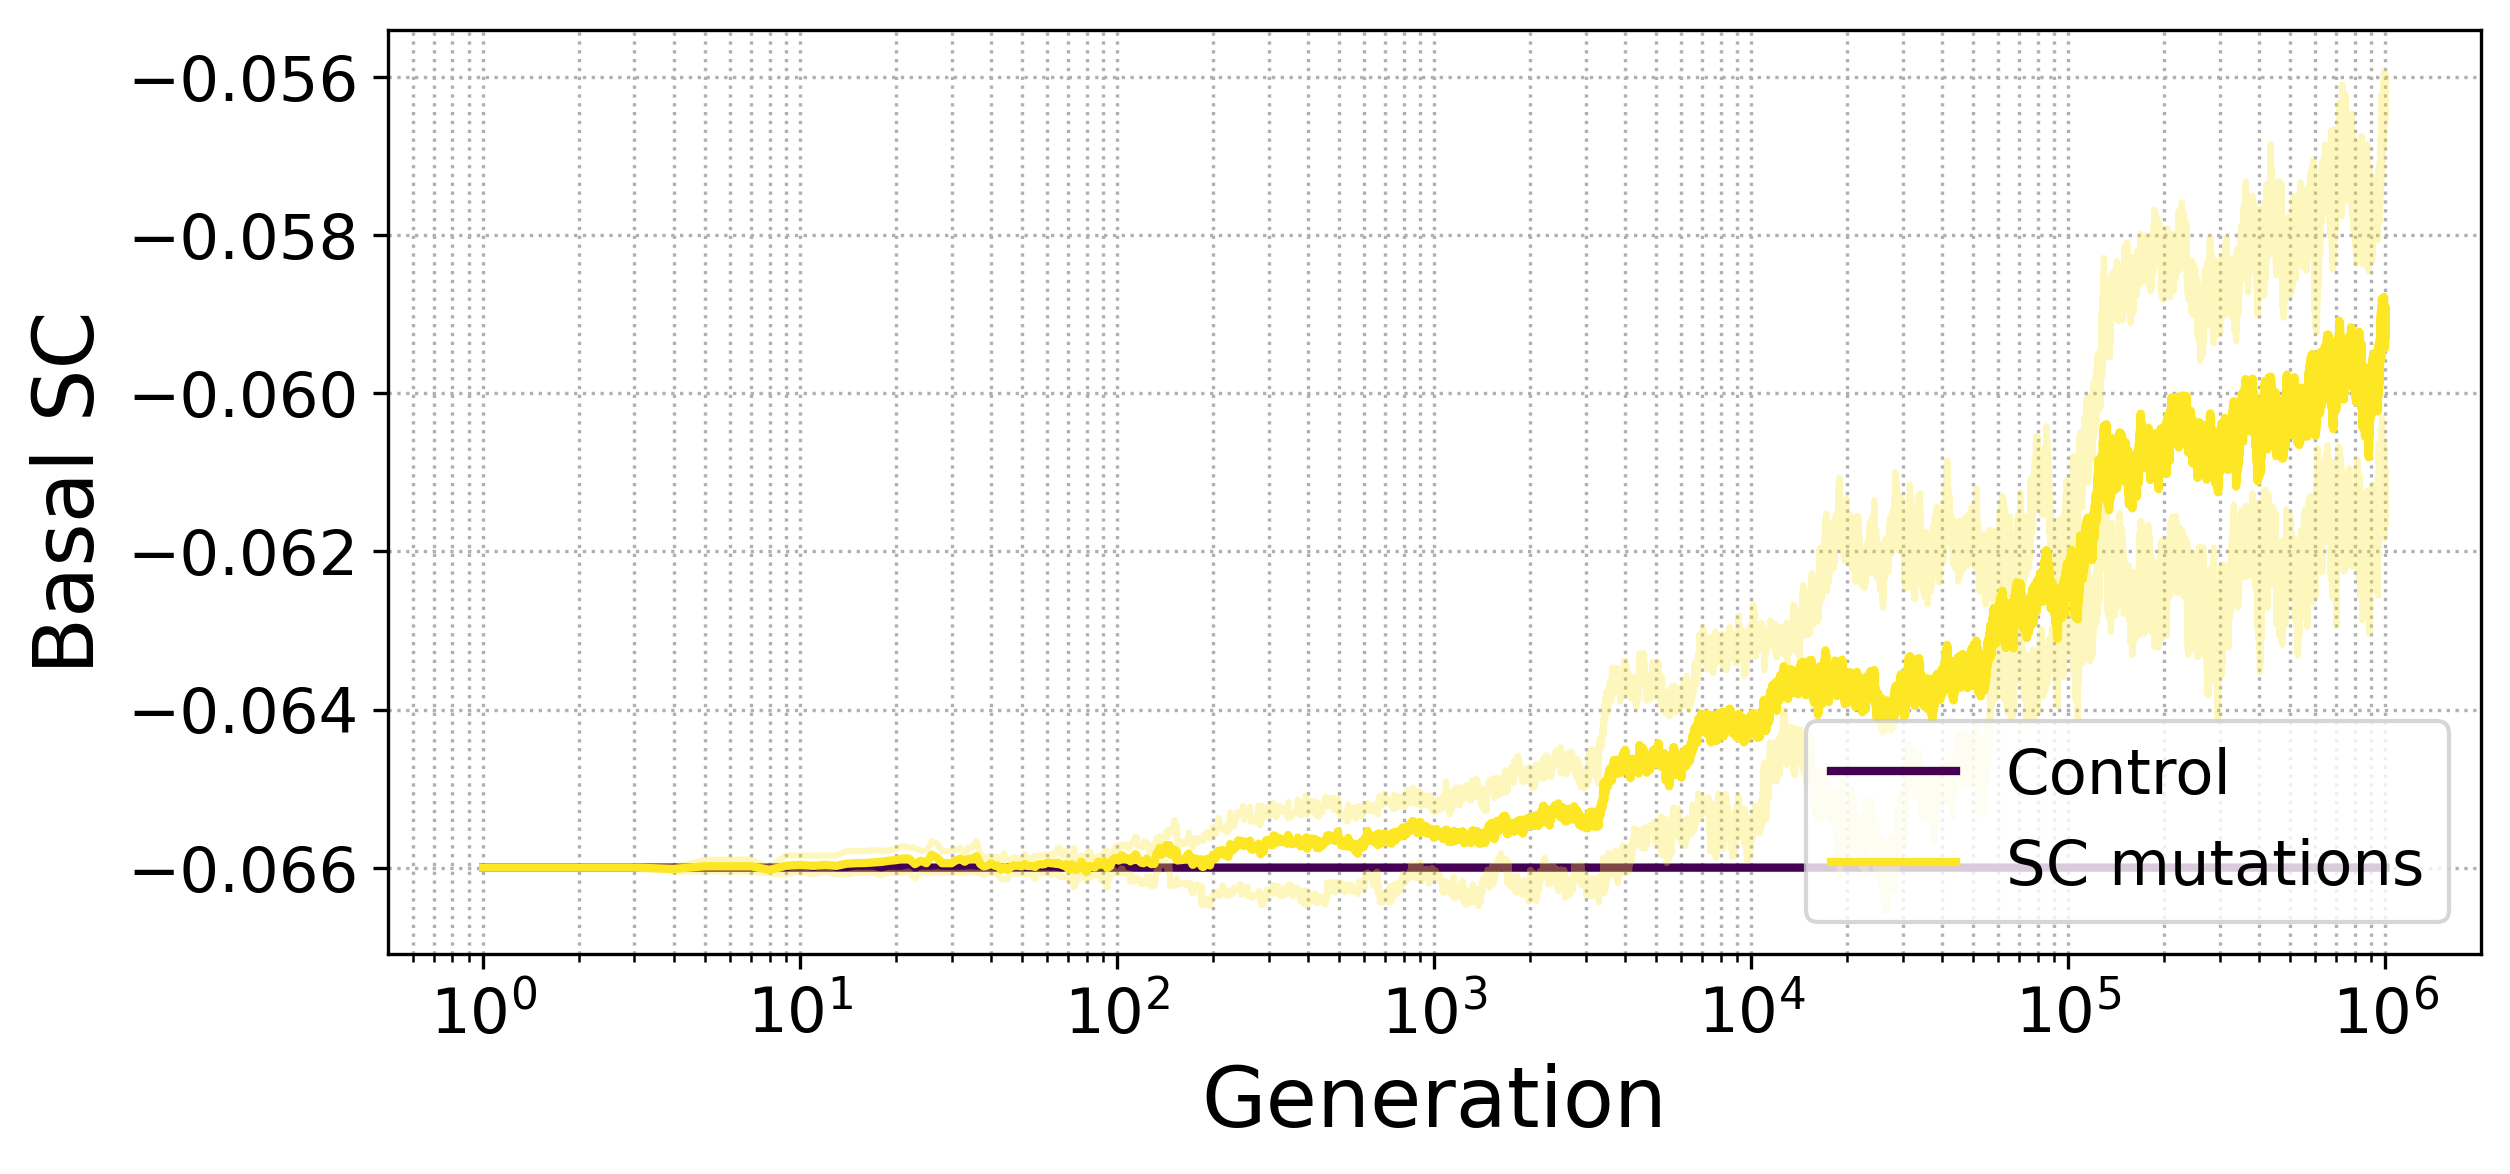

In [17]:
plot_basal_sc(sc_stats, sc_path)

In [18]:
def plot_basal_sc_all(full_stats, exp_path):
    
    max_gen = full_stats.groupby('Replicate').max()['Gen'].min()
    nb_reps = full_stats['Replicate'].nunique()
    
    stats = full_stats[(full_stats["Gen"] > 0) & (full_stats['Gen'] <= max_gen)][['Gen', 'Basal SC']].copy()
        
    mean_data = stats.groupby('Gen').mean().reset_index()
    
    # Note: for the fitness, the mean can be above the quantile
    first_dec = stats.groupby('Gen').quantile(0.1)
    last_dec = stats.groupby('Gen').quantile(0.9)
    
    color = 'tab:pink'
    colors = mpl.cm.get_cmap('viridis', nb_reps)(range(nb_reps))
    
    plt.figure(figsize=(9,4), dpi=dpi)
    
    #plt.xscale('log')
    #plt.yscale('log')
    plt.grid(linestyle=':')
    plt.grid(visible=True, which="minor", axis='x', linestyle=':')
    
    plt.xlabel('Generation', fontsize=label_fontsize)

    plt.ylabel('Basal SC', fontsize=label_fontsize)
    
    plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    for rep in range(nb_reps):
        stats_rep = full_stats[full_stats['Replicate'] == rep]
        plt.plot(stats_rep['Gen'], stats_rep['Basal SC'], color=colors[rep], linewidth=2)
            
    plt.savefig(f'{exp_path}/all_basal_sc.pdf', dpi=dpi, bbox_inches='tight')

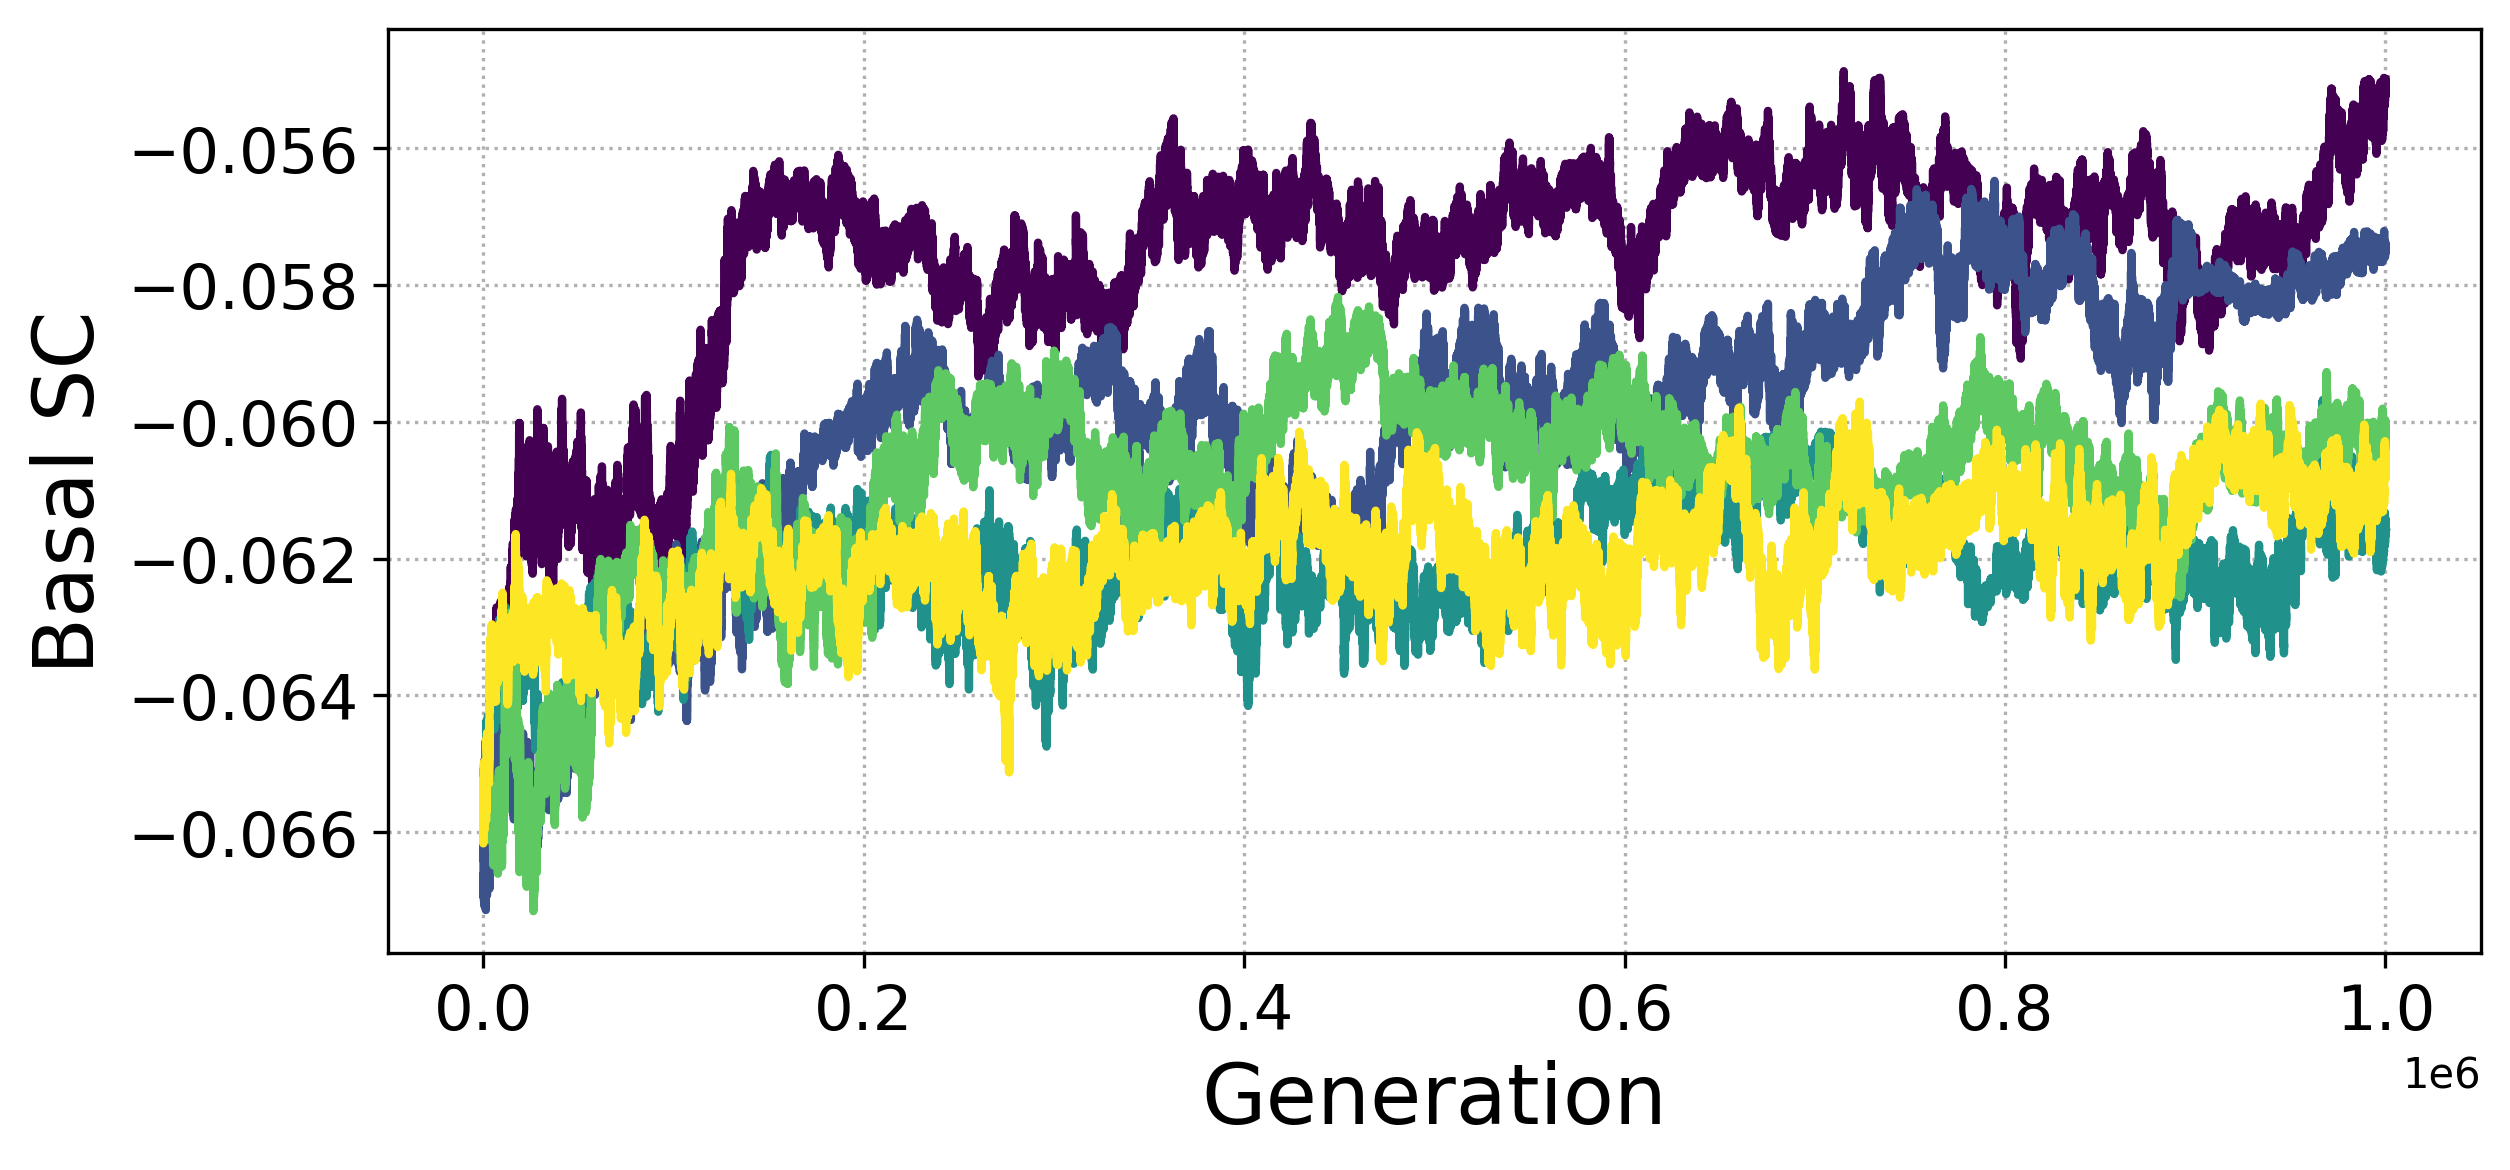

In [19]:
plot_basal_sc_all(sc_stats, sc_path)

# New plots for the continuous model

In [29]:
indiv = evotsc_lib.get_best_indiv(control_path.joinpath('rep00'), gen=gen)

In [71]:
def plot_indiv(indiv, sigma_env, plot_name):
        
    expr, fit = indiv.evaluate(sigma_env)

    gene_exprs = [(expr[-1, i_gene], gene.expr_target)
                  for i_gene, gene in enumerate(indiv.genes)]

    sorted_gene_exprs = sorted(gene_exprs, key=lambda x: x[1])

    exprs = [p[0] for p in sorted_gene_exprs]
    targets = [p[1] for p in sorted_gene_exprs]
    
    colors = mpl.cm.get_cmap('jet', indiv.nb_genes)(range(indiv.nb_genes))

    # Plot
    plt.figure(figsize=(8,5), dpi=dpi)

    plt.bar(np.arange(indiv.nb_genes) + 0.5, height=targets, width=1, color=colors) 
    #plt.plot(np.arange(indiv.nb_genes), targets, linestyle='-', color='tab:green')
    plt.plot(np.arange(indiv.nb_genes) + 0.5, exprs, linestyle='-', color='black')

    plt.xlabel('Gene rank (by increasing target)')
    plt.ylabel('Expression level')
    plt.ylim(-0.05, 1.05)
    plt.grid(linestyle=':')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    #plt.legend()

    #plt.title(f'Fitness: {fit:.3}')
    
    plt.savefig(plot_name, bbox_inches='tight', dpi=dpi)

    plt.show()

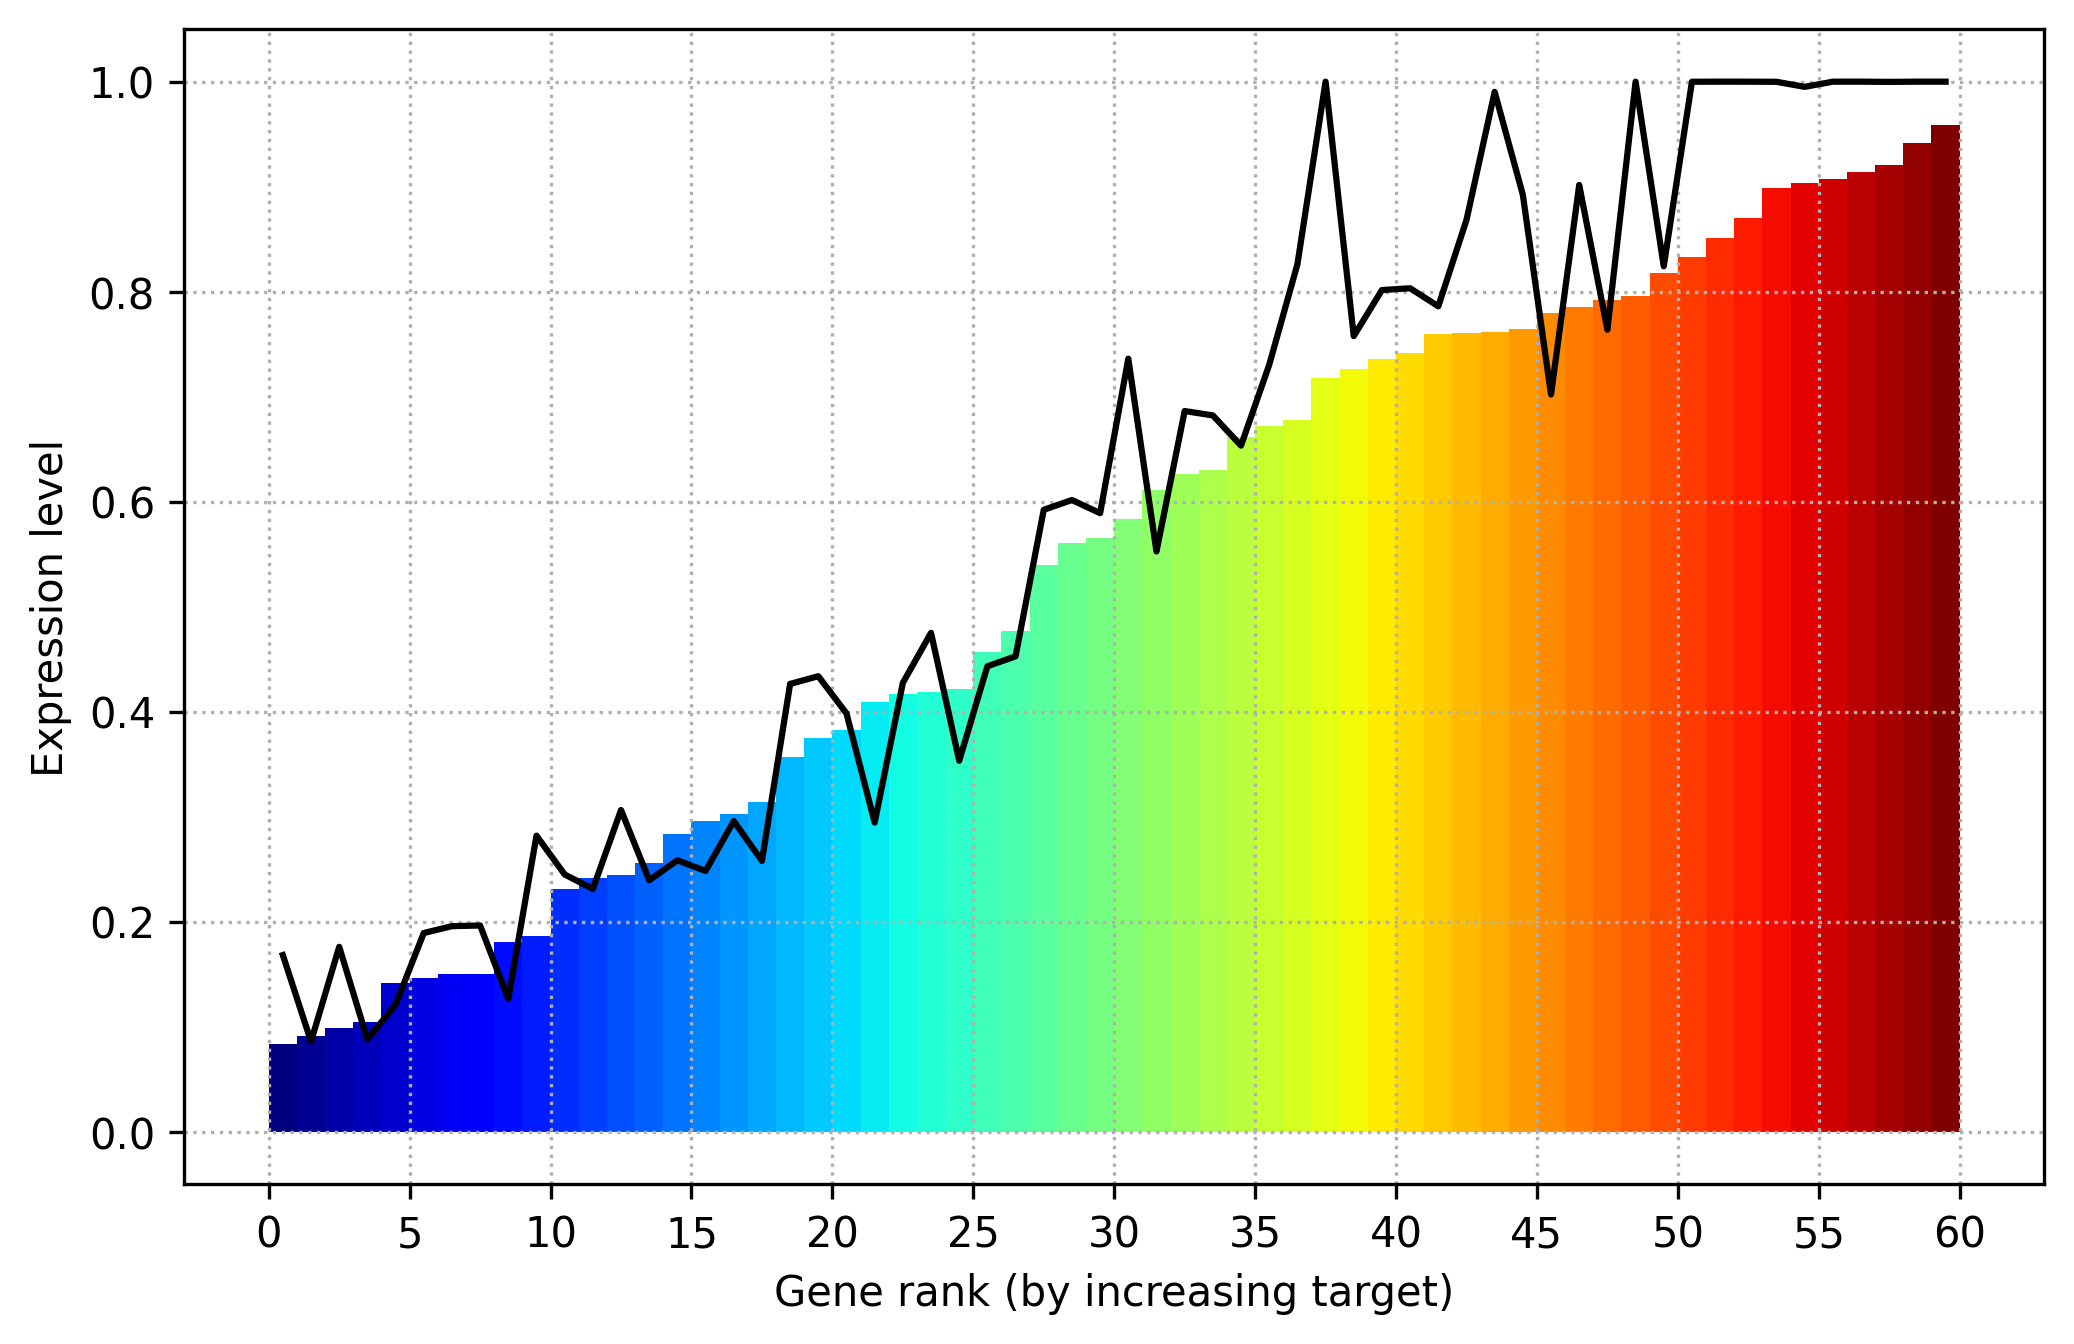

In [72]:
plot_indiv(indiv, sc_params['sigma_env'], 'shuffle_no.pdf')

In [67]:
def plot_best_indiv(exp_path, params, gen):
    
    rep_dirs = sorted([d for d in exp_path.iterdir() if (d.is_dir() and d.name.startswith("rep"))])
    
    for rep, rep_dir in enumerate(rep_dirs):

        best_indiv = evotsc_lib.get_best_indiv(rep_dir, gen=gen)

        plot_indiv(best_indiv, params['sigma_env'], exp_path.joinpath(f'best_rep{rep:02}.pdf'))

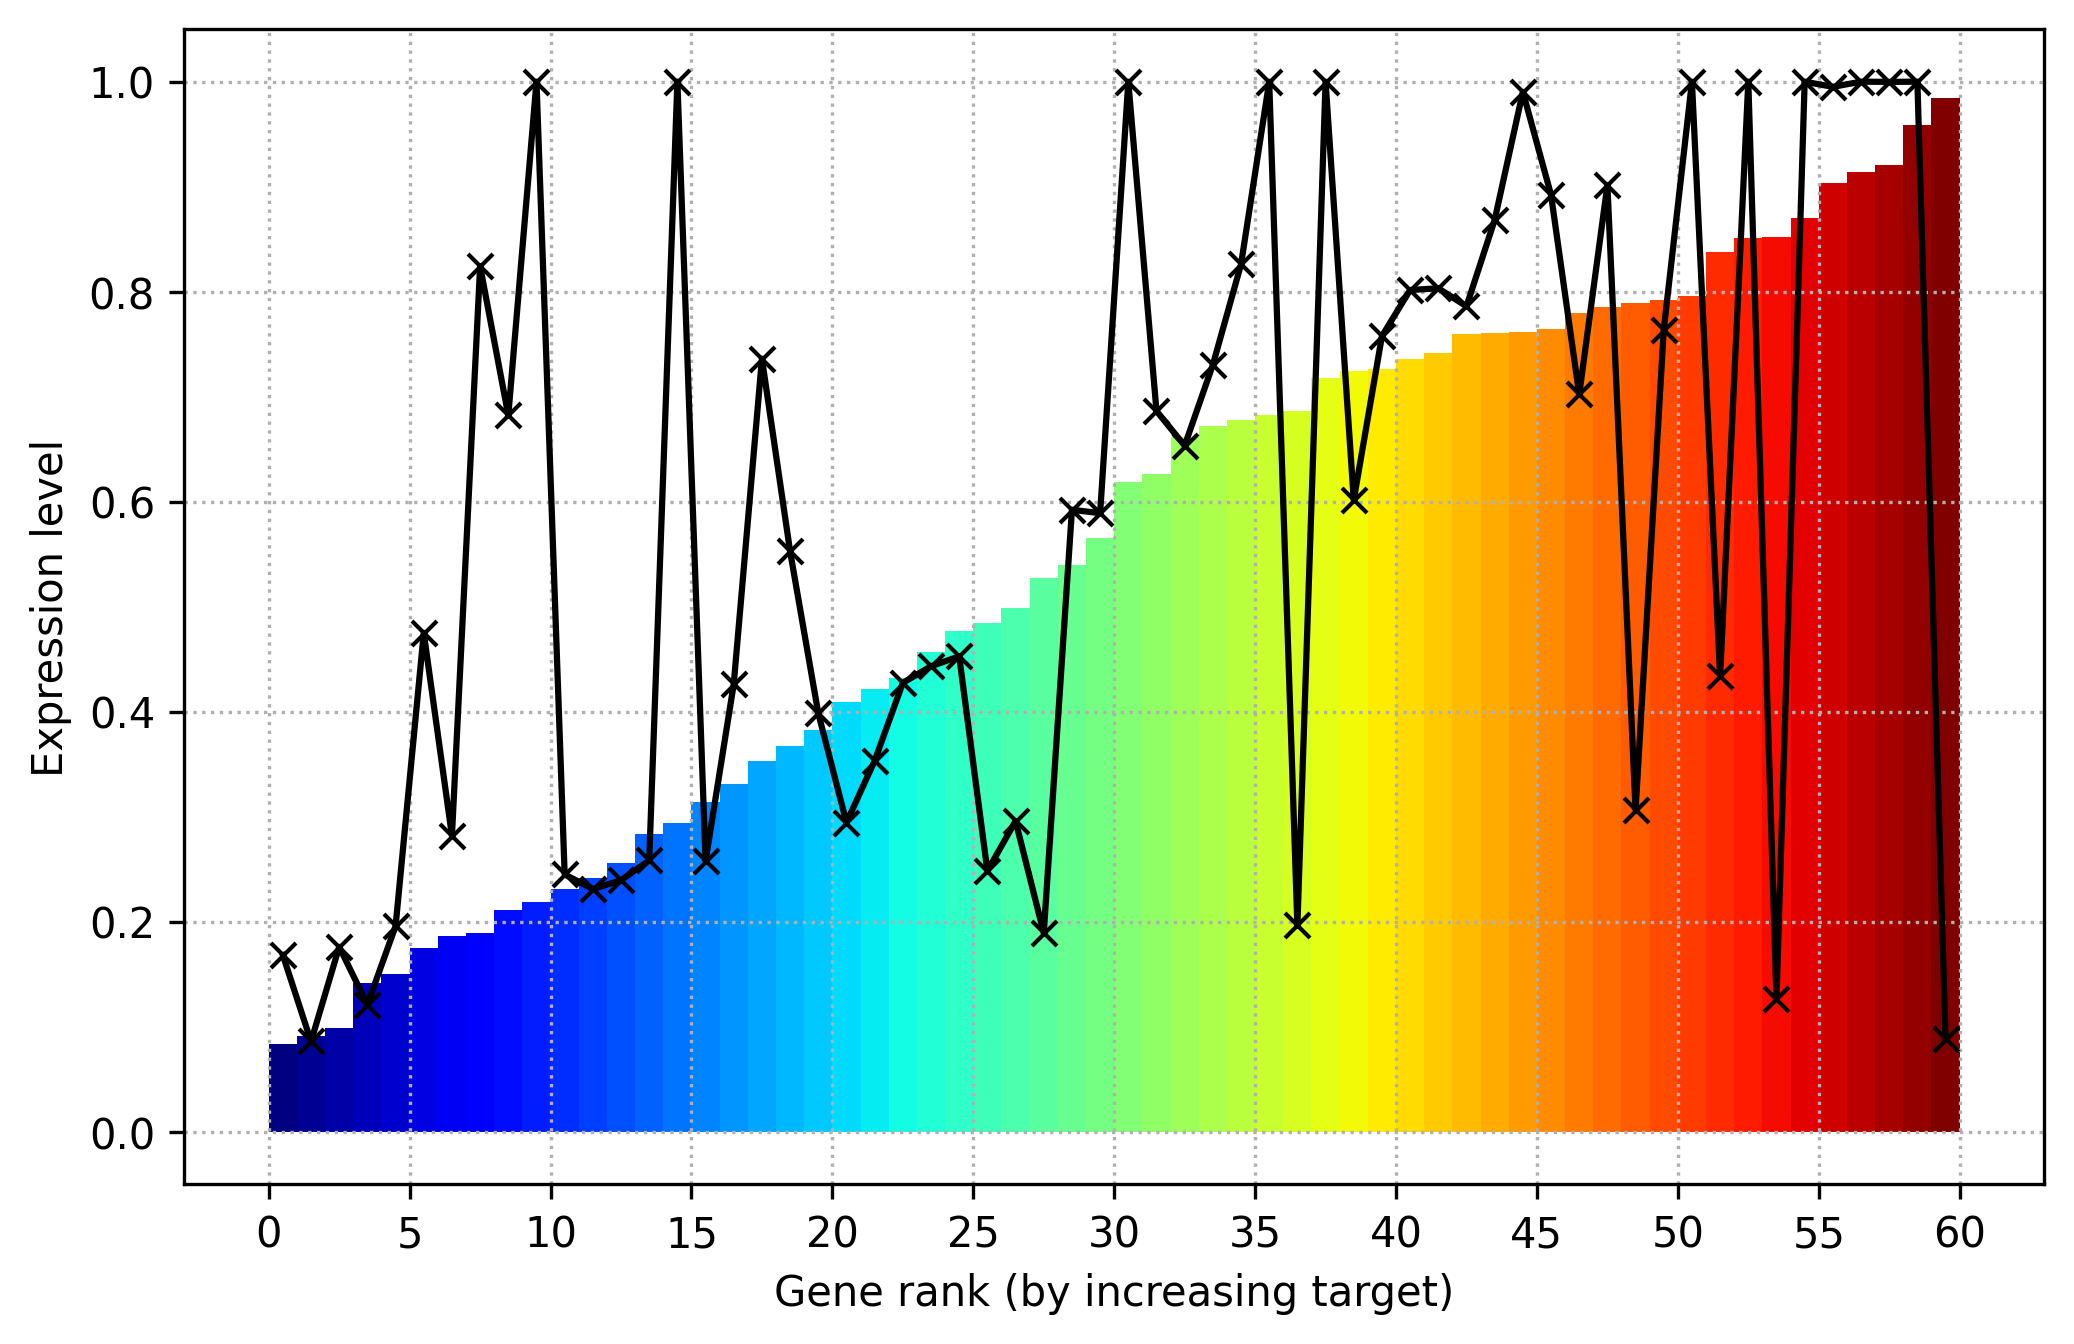

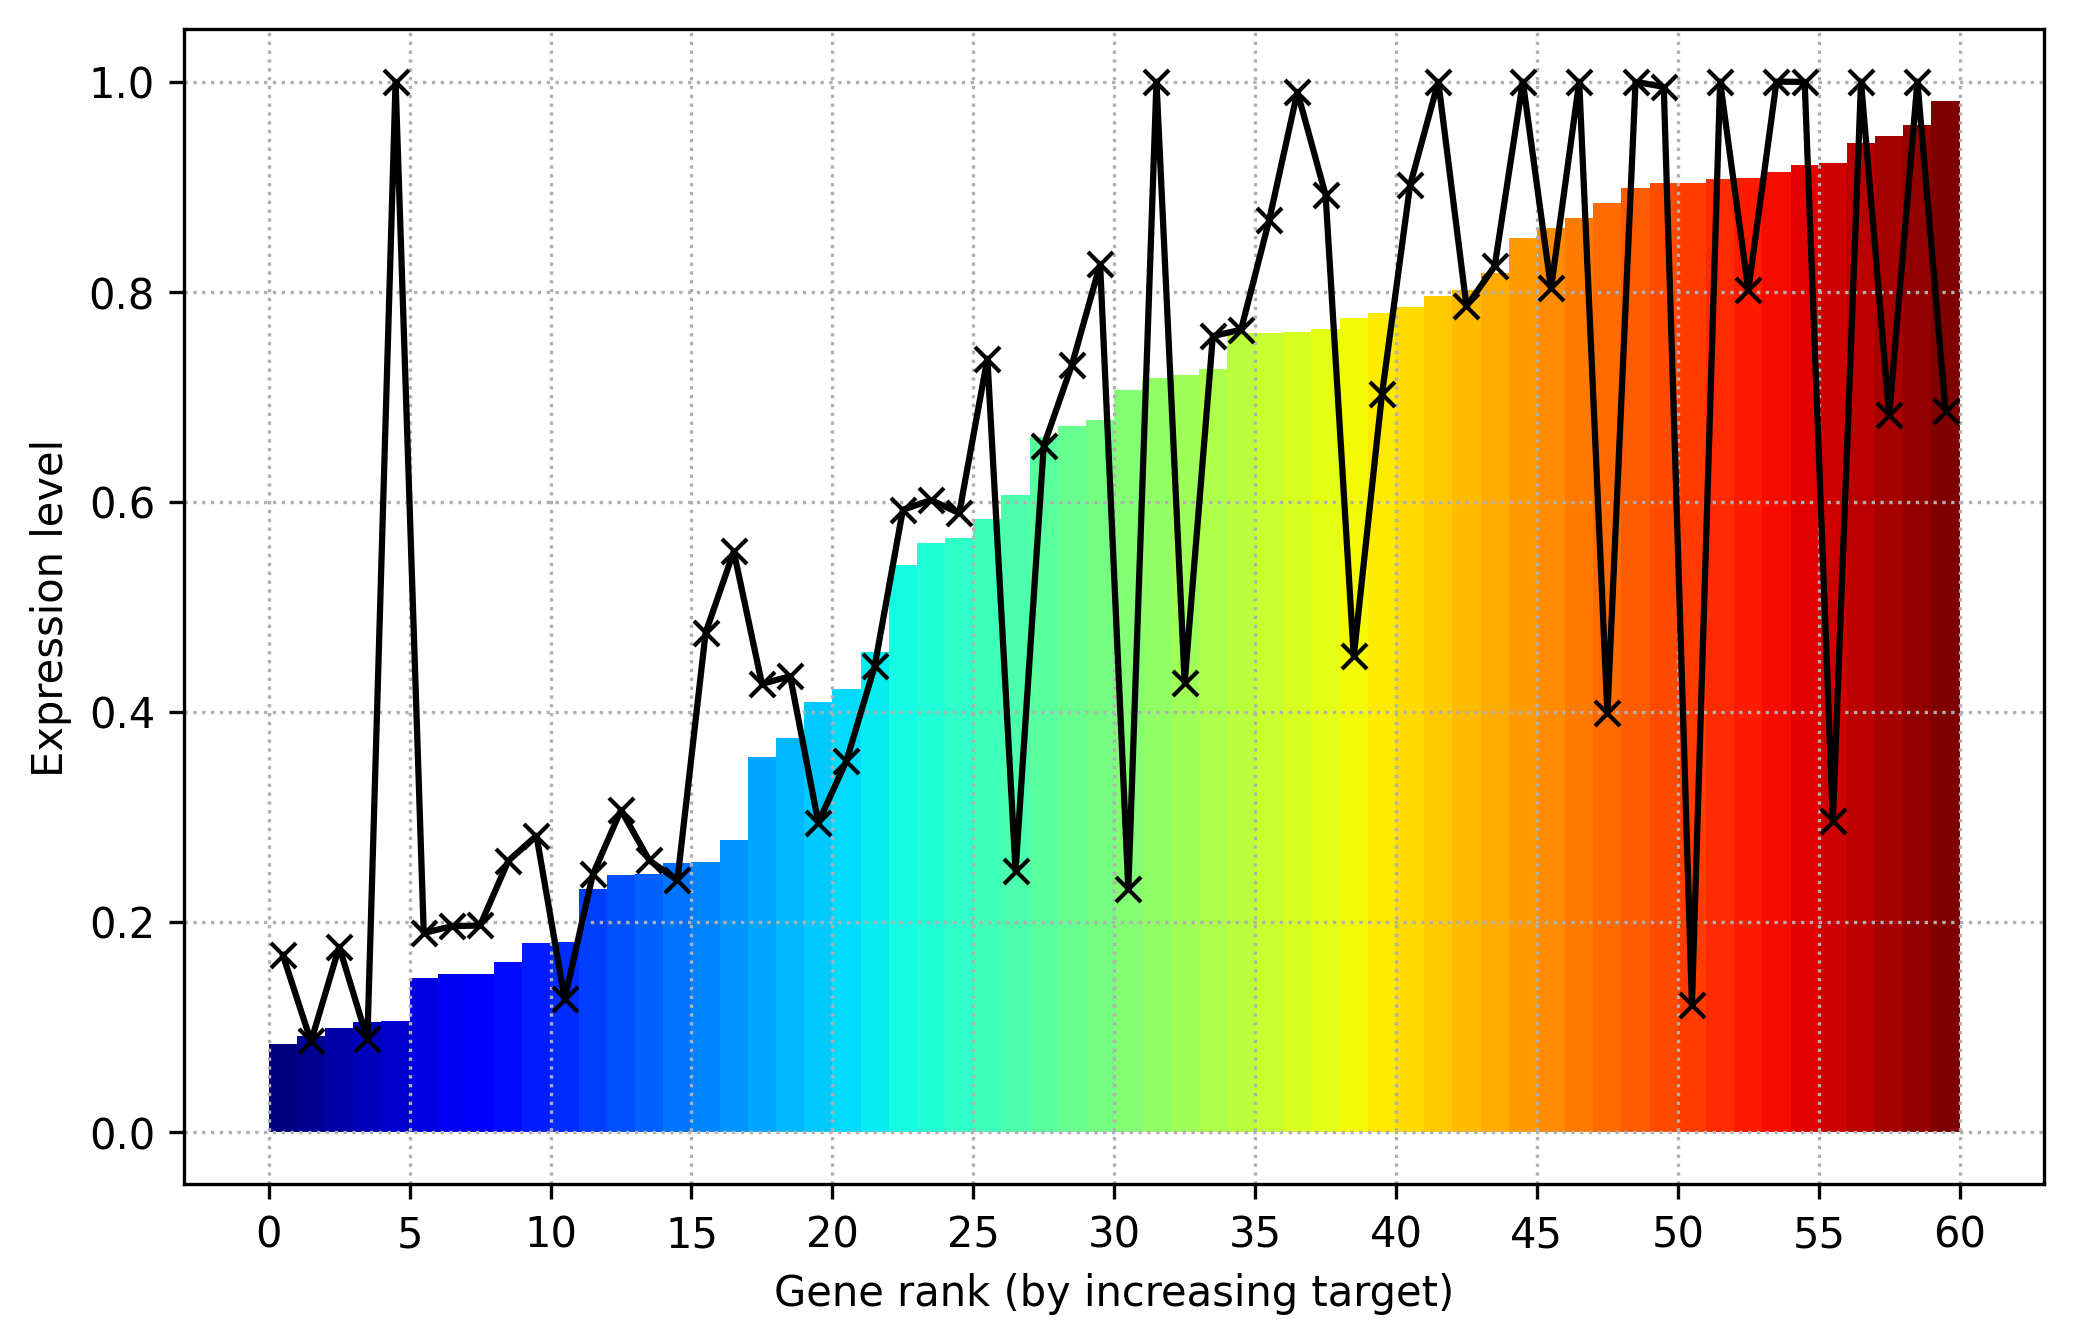

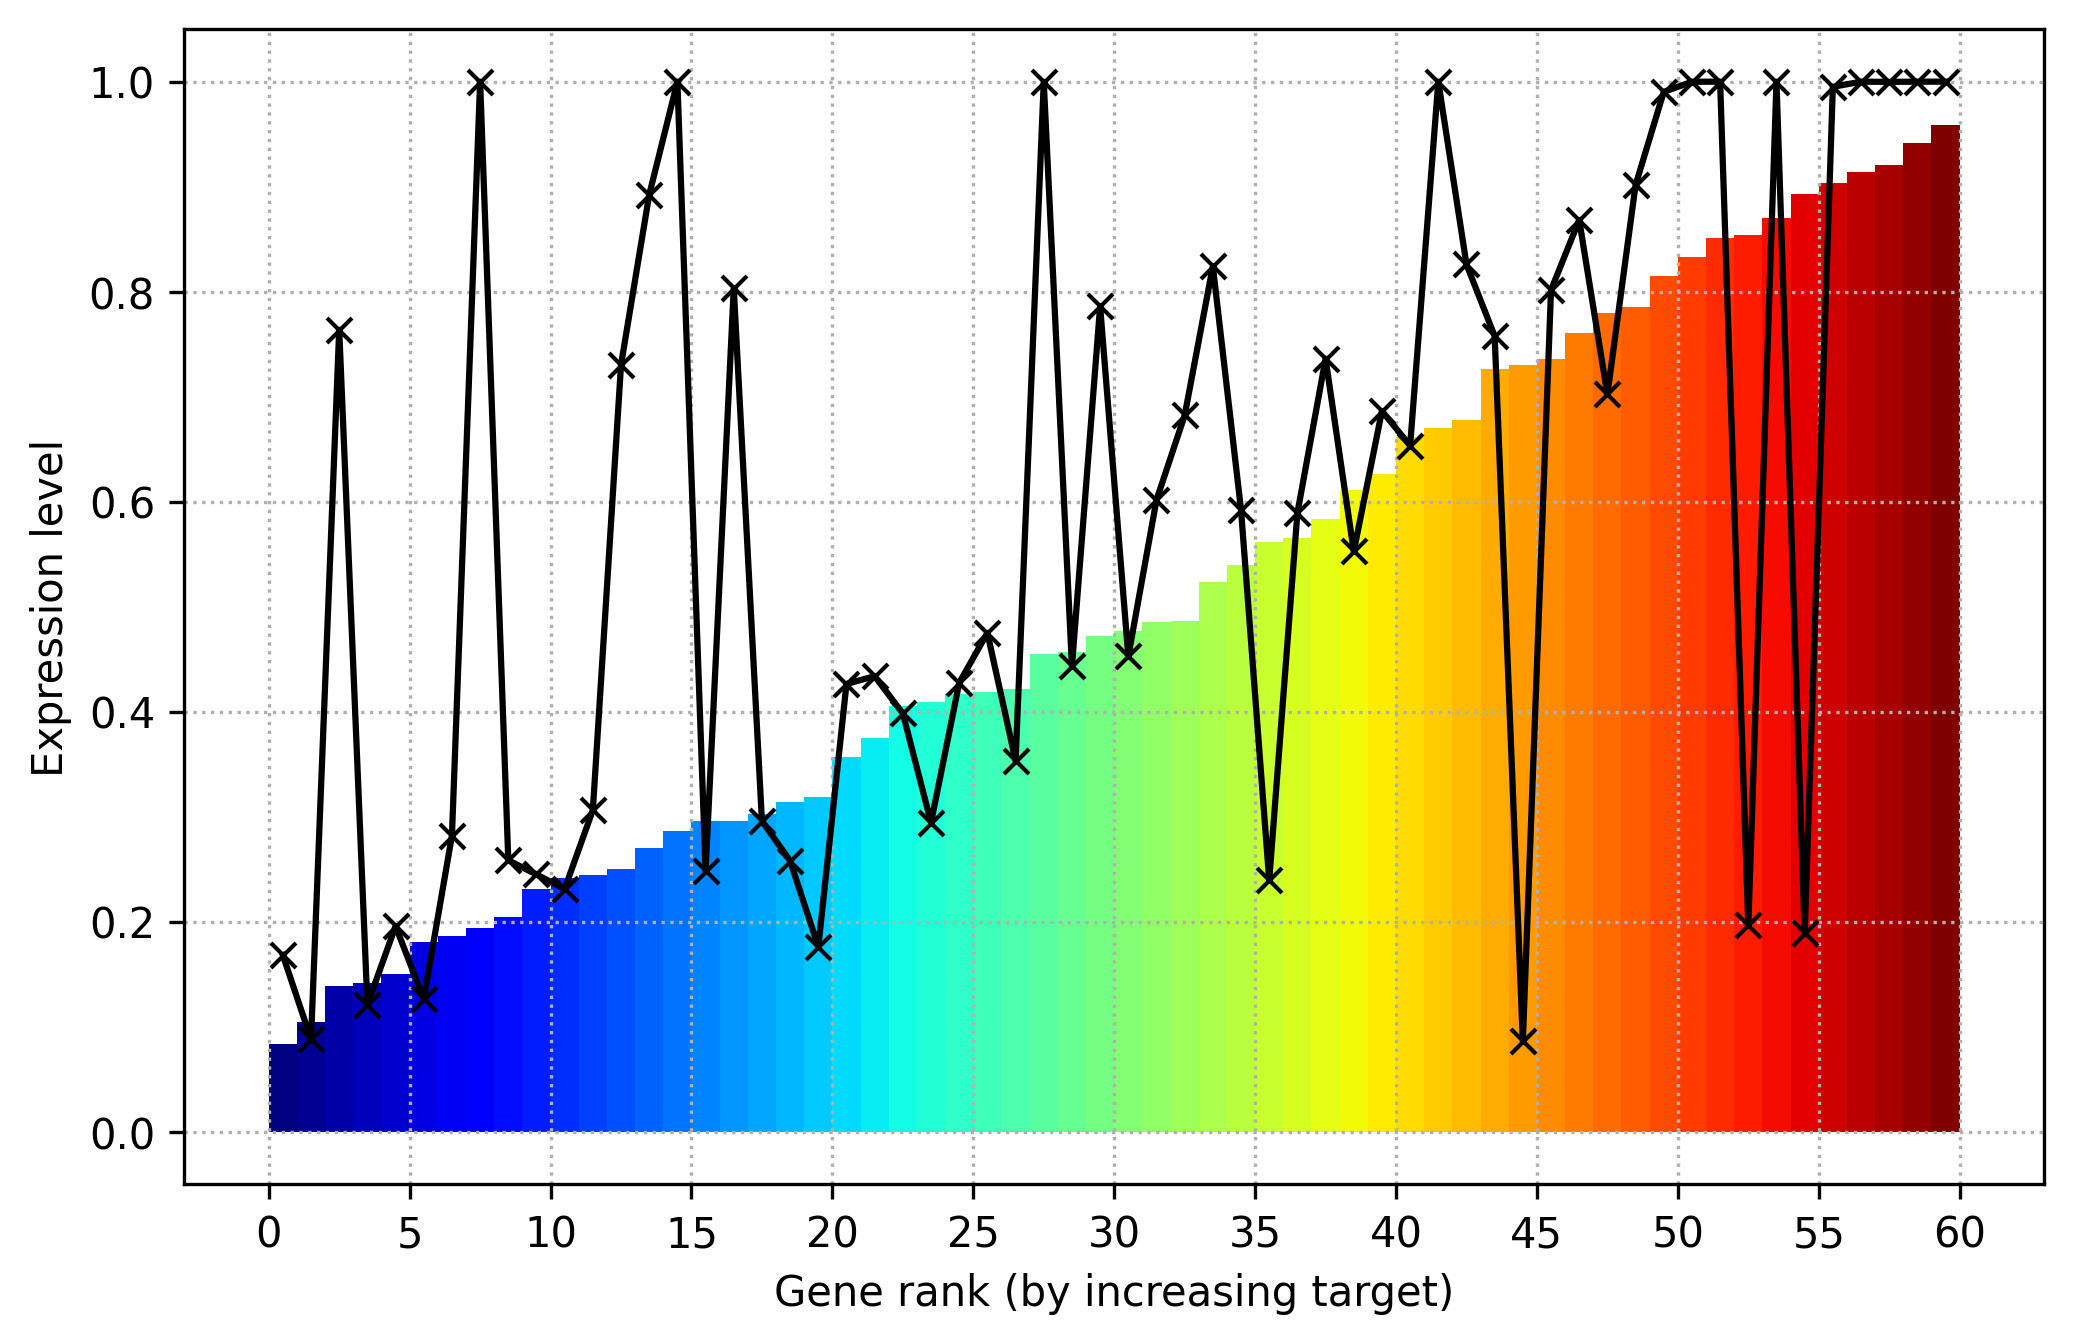

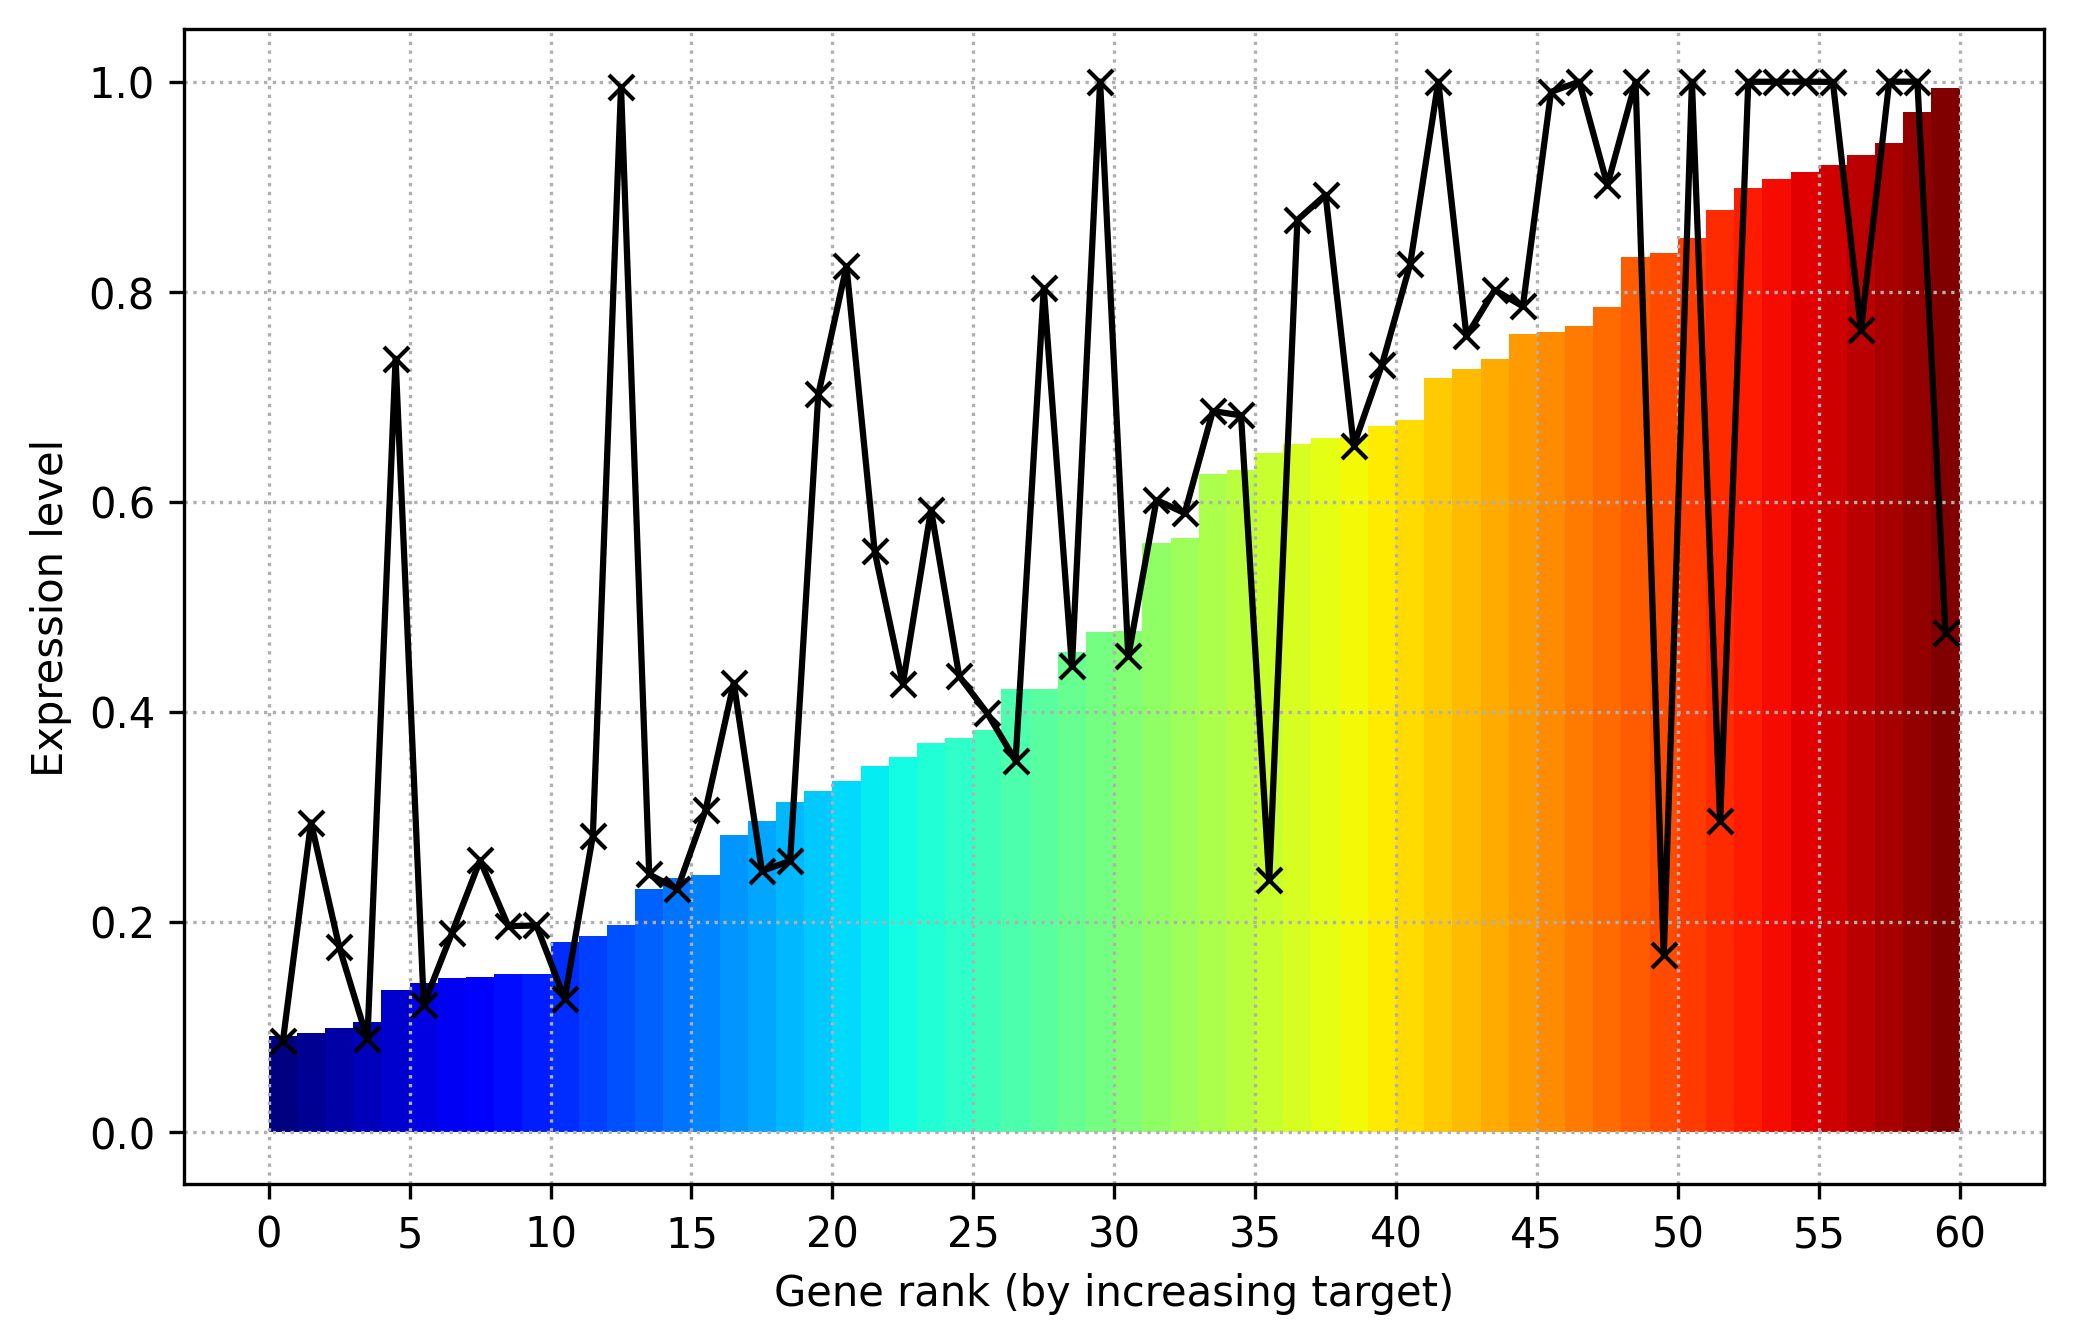

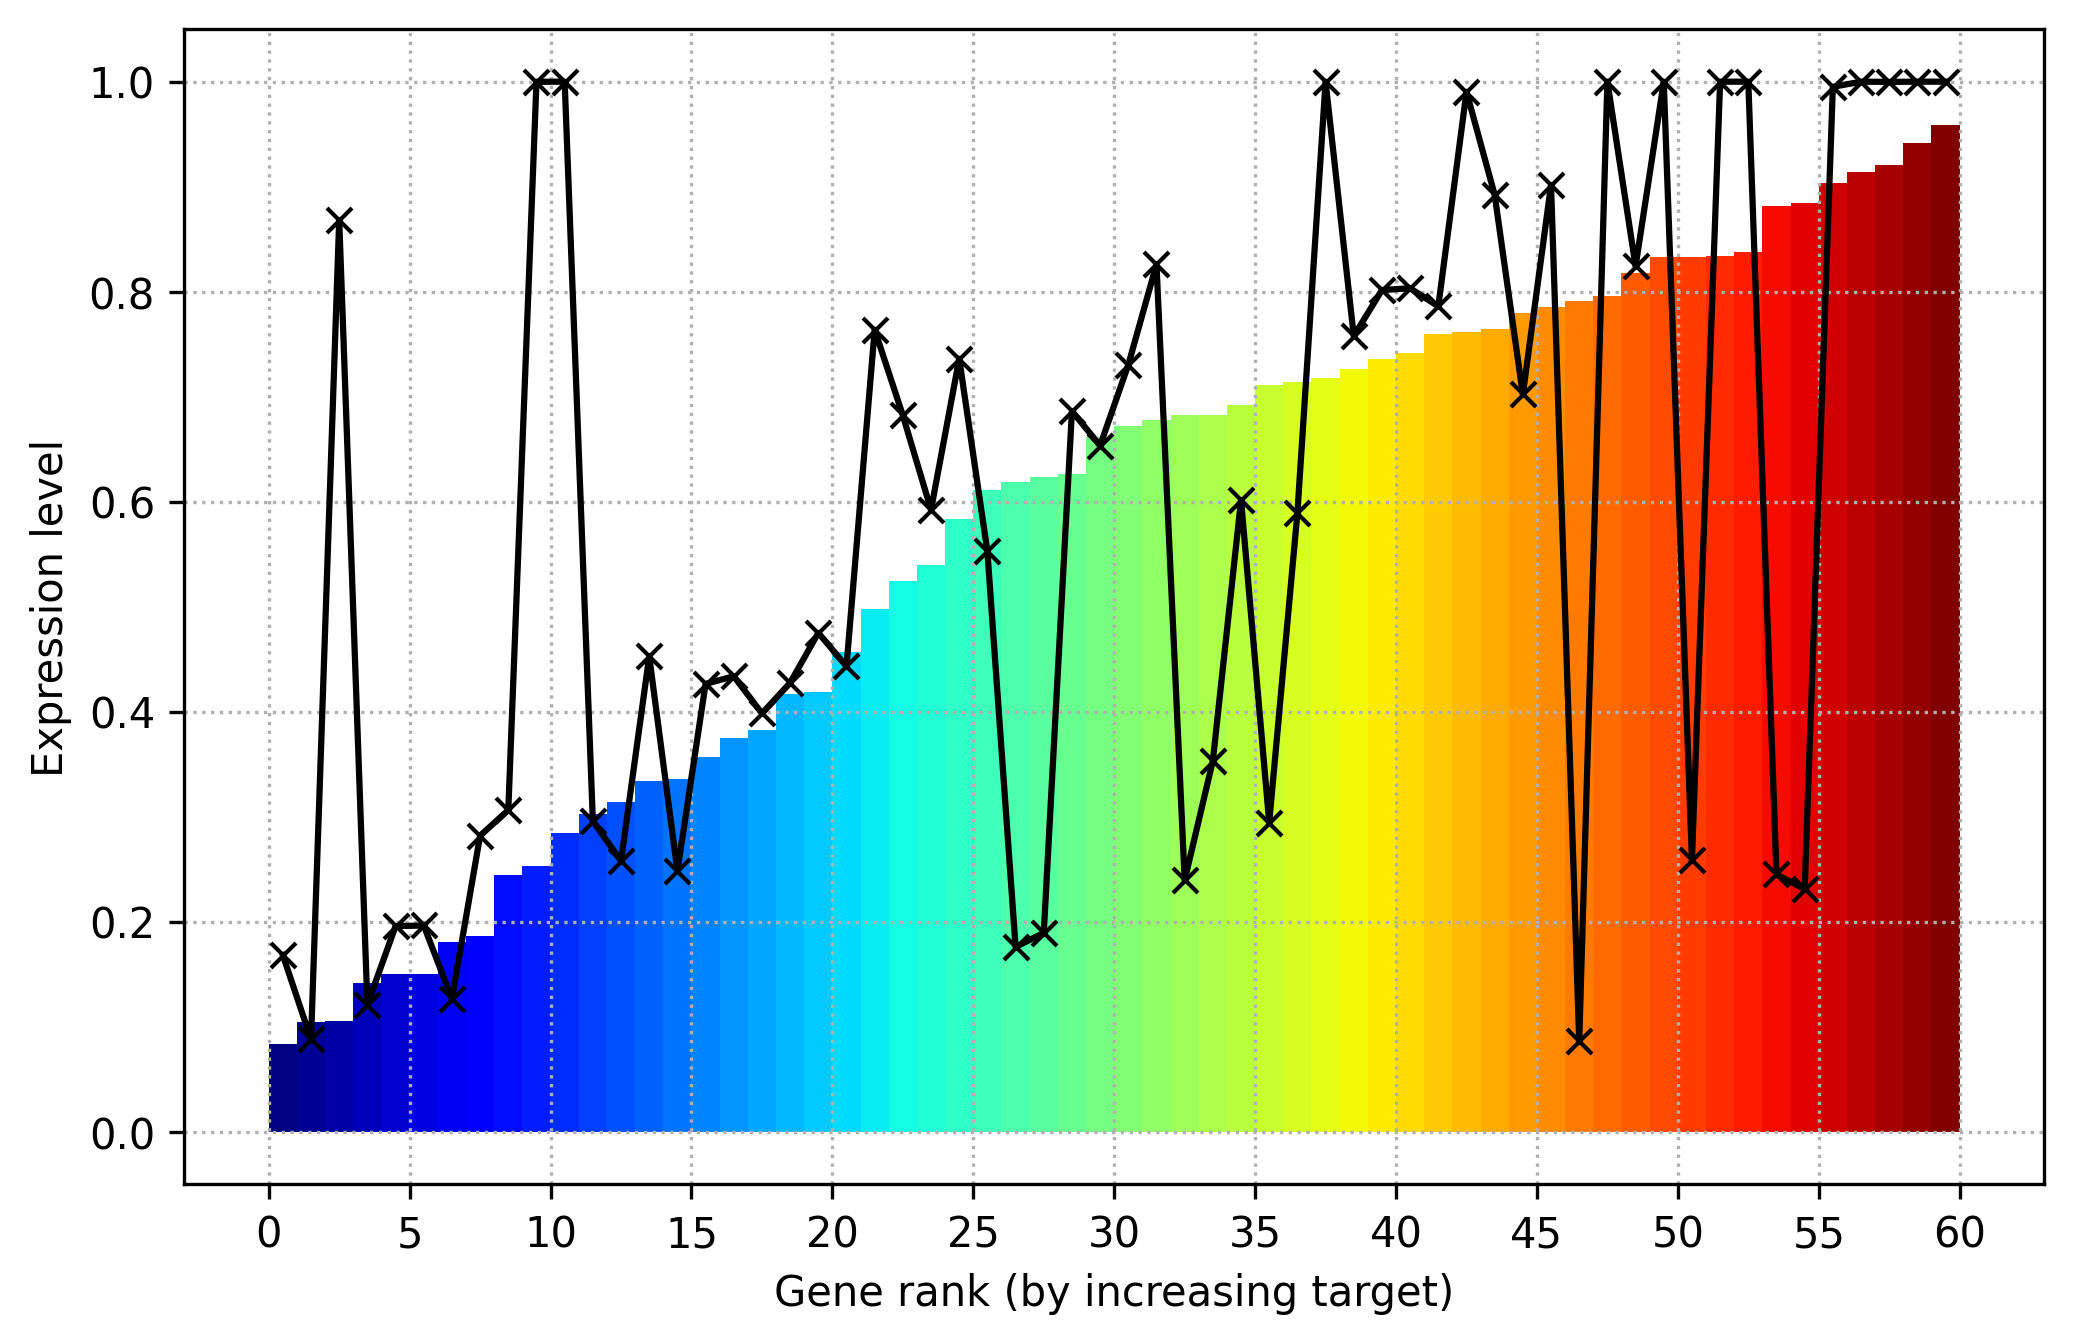

In [68]:
for i in range(5):
    shuffled_indiv = evotsc_lib.shuffle_indiv(indiv=indiv,
                                              nb_genes_to_shuffle=indiv.nb_genes // 3, rng=indiv.rng)
    plot_indiv(shuffled_indiv, sc_params['sigma_env'], f'shuffle_{i}.pdf')
    with open(f'shuffled_indiv_{i}.evotsc', 'wb') as save_file:
        pickle.dump(shuffled_indiv, save_file)

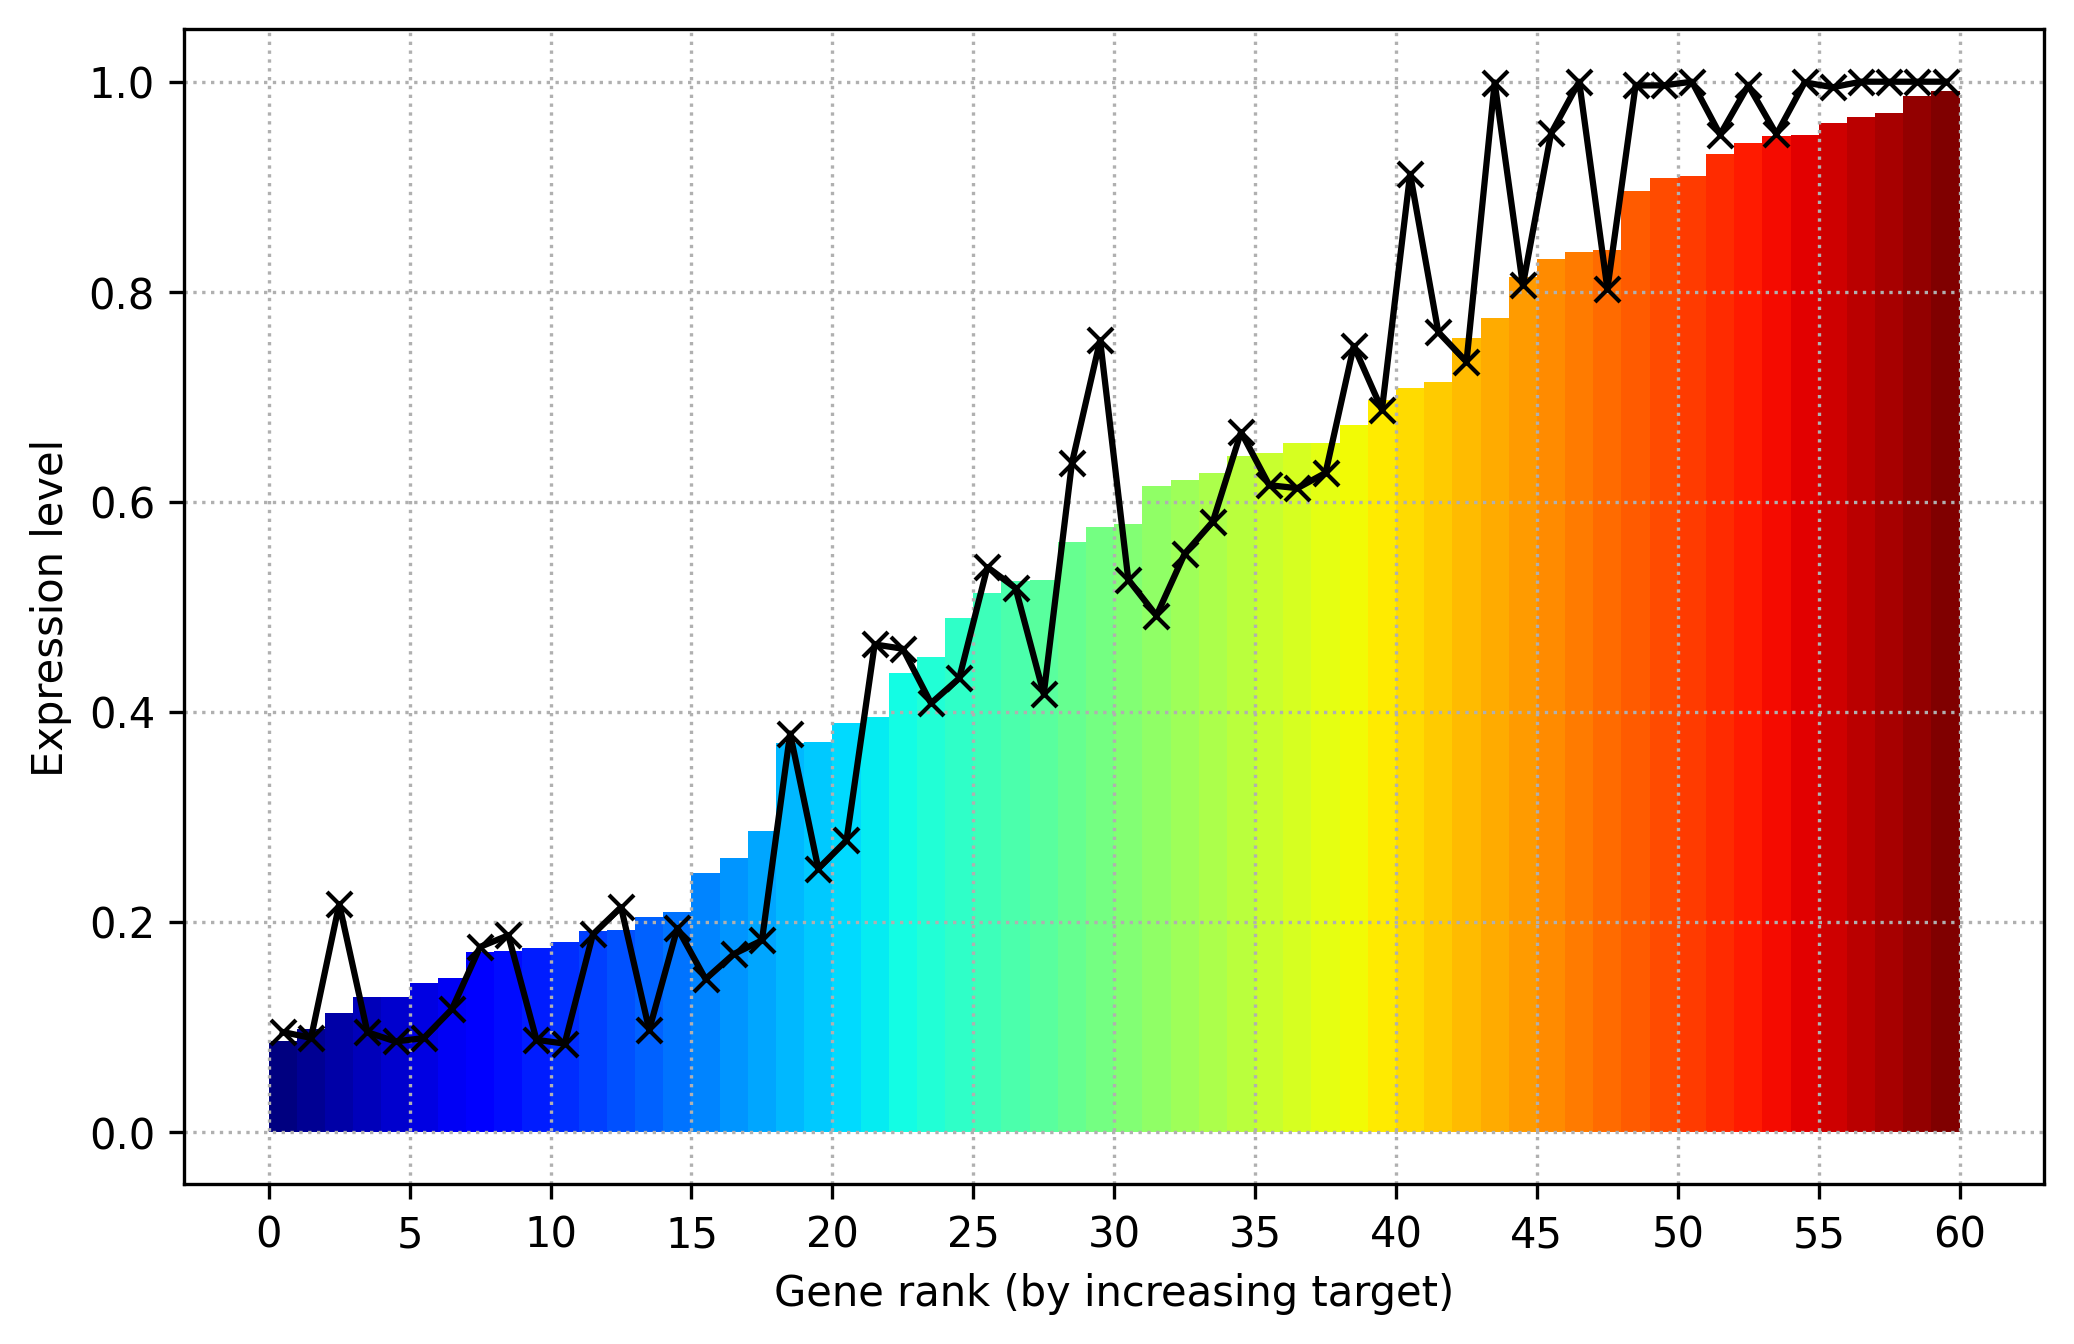

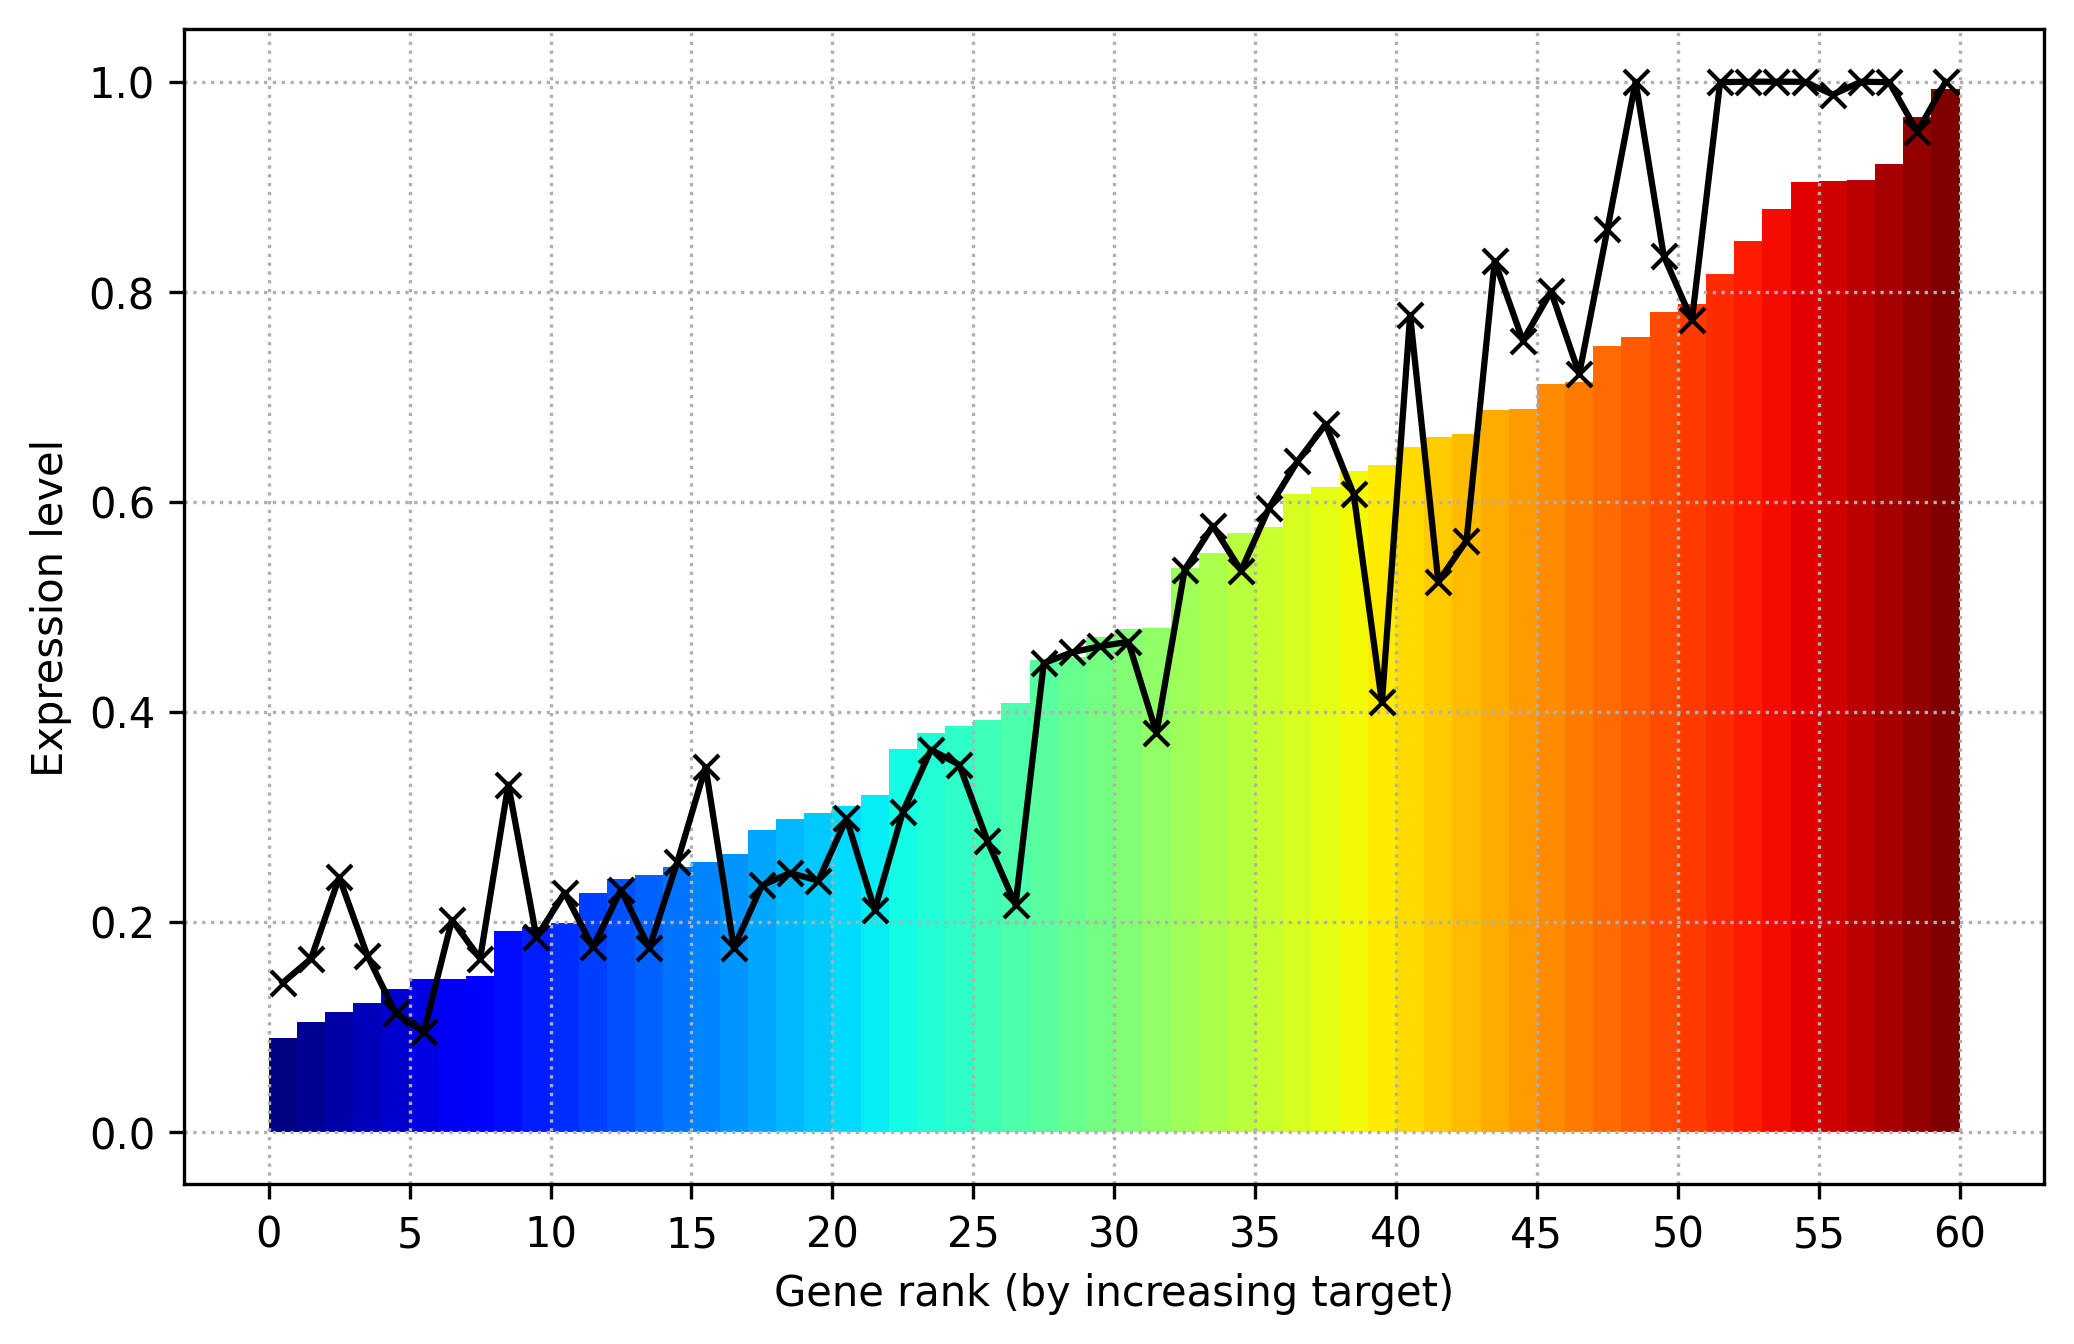

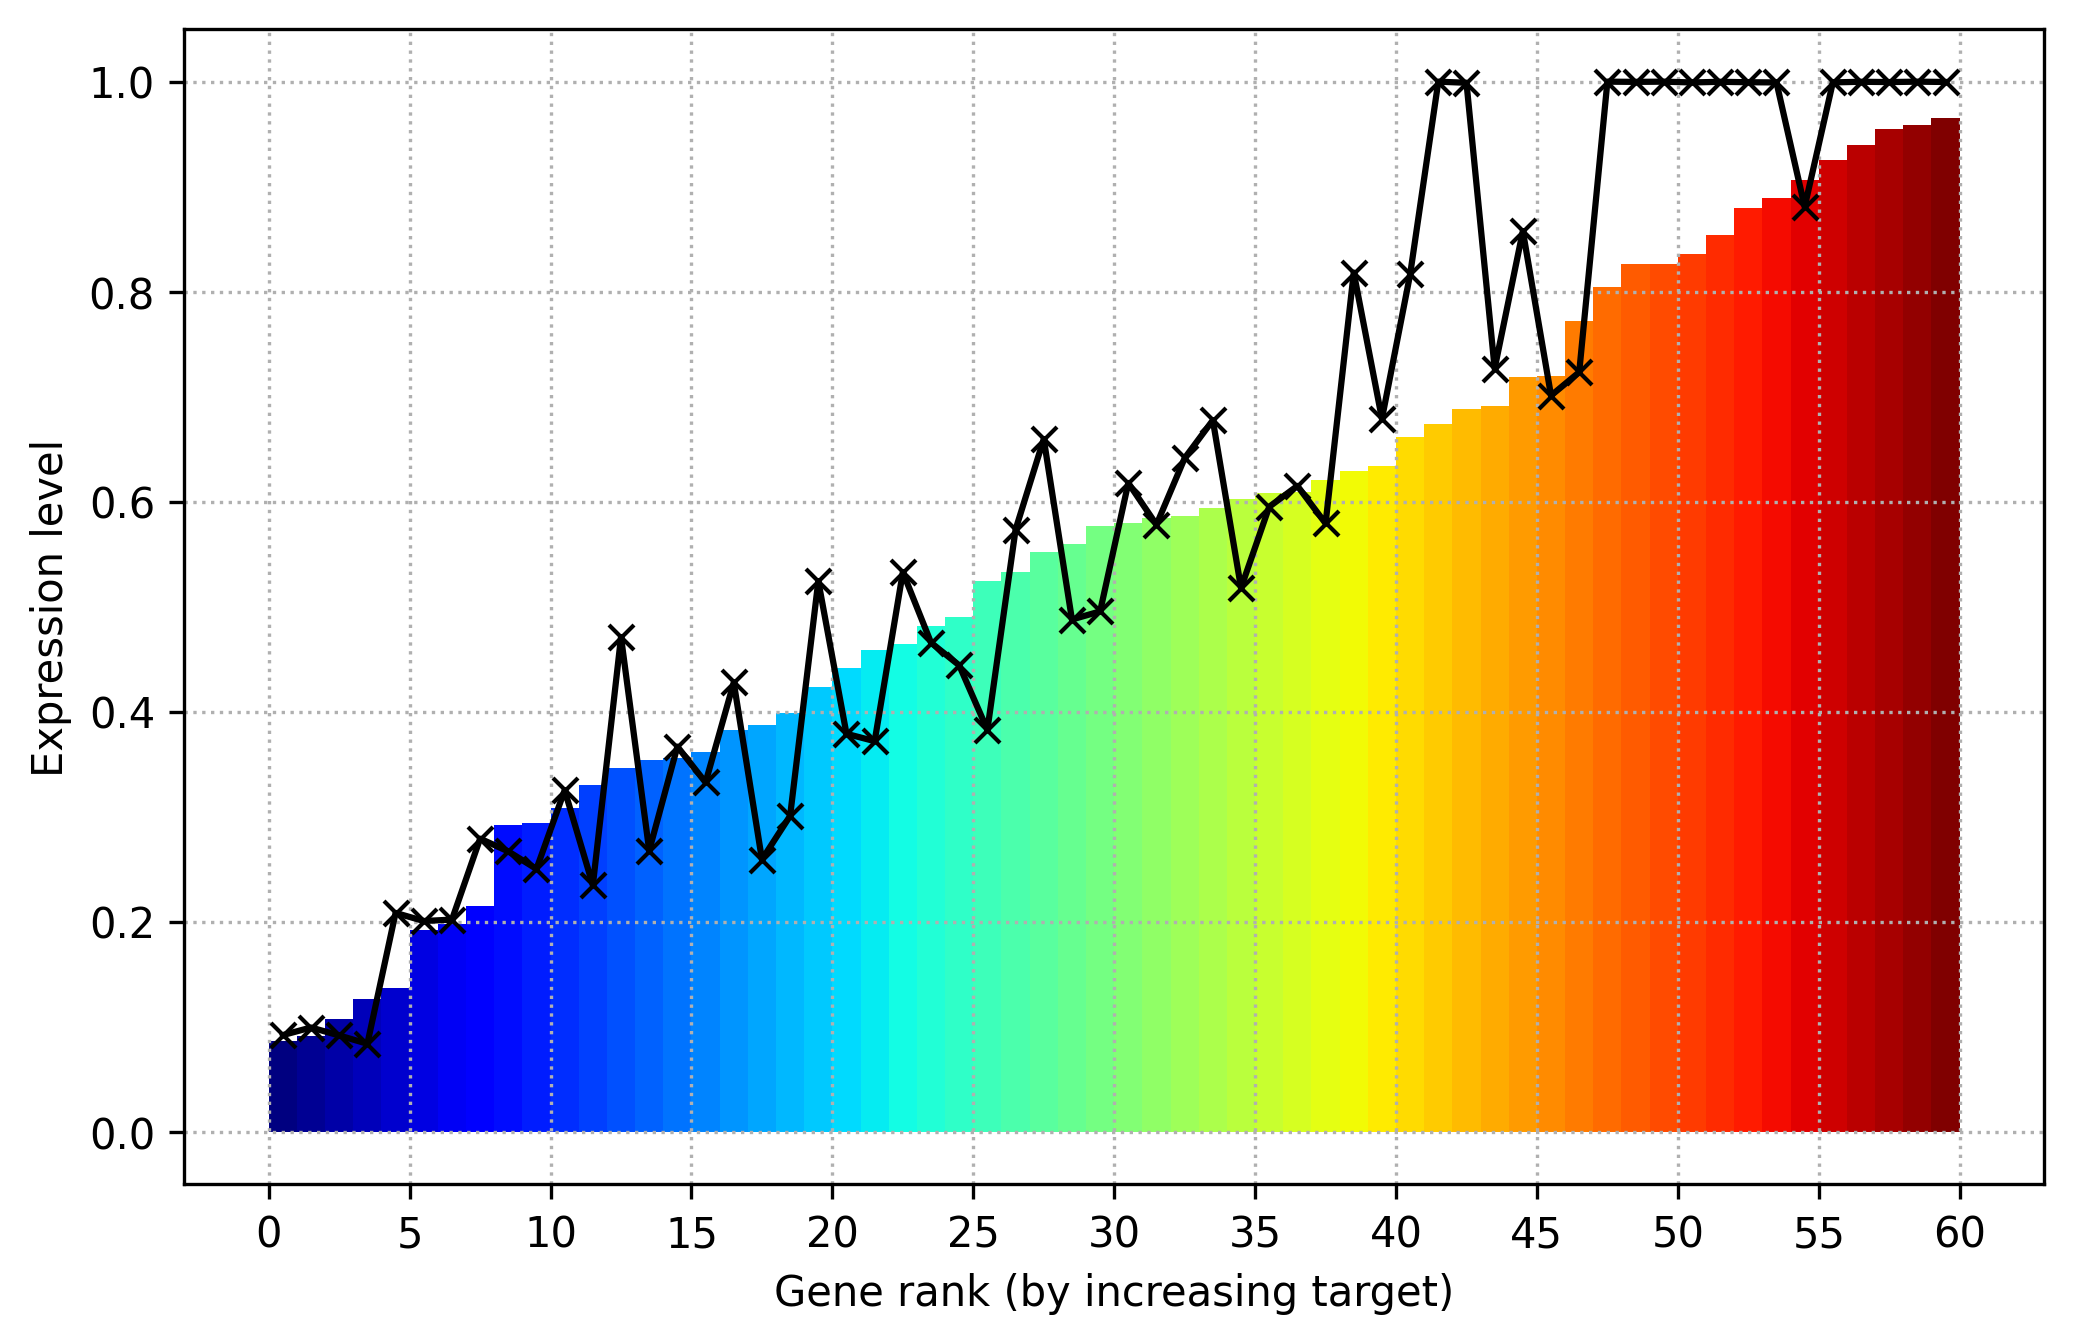

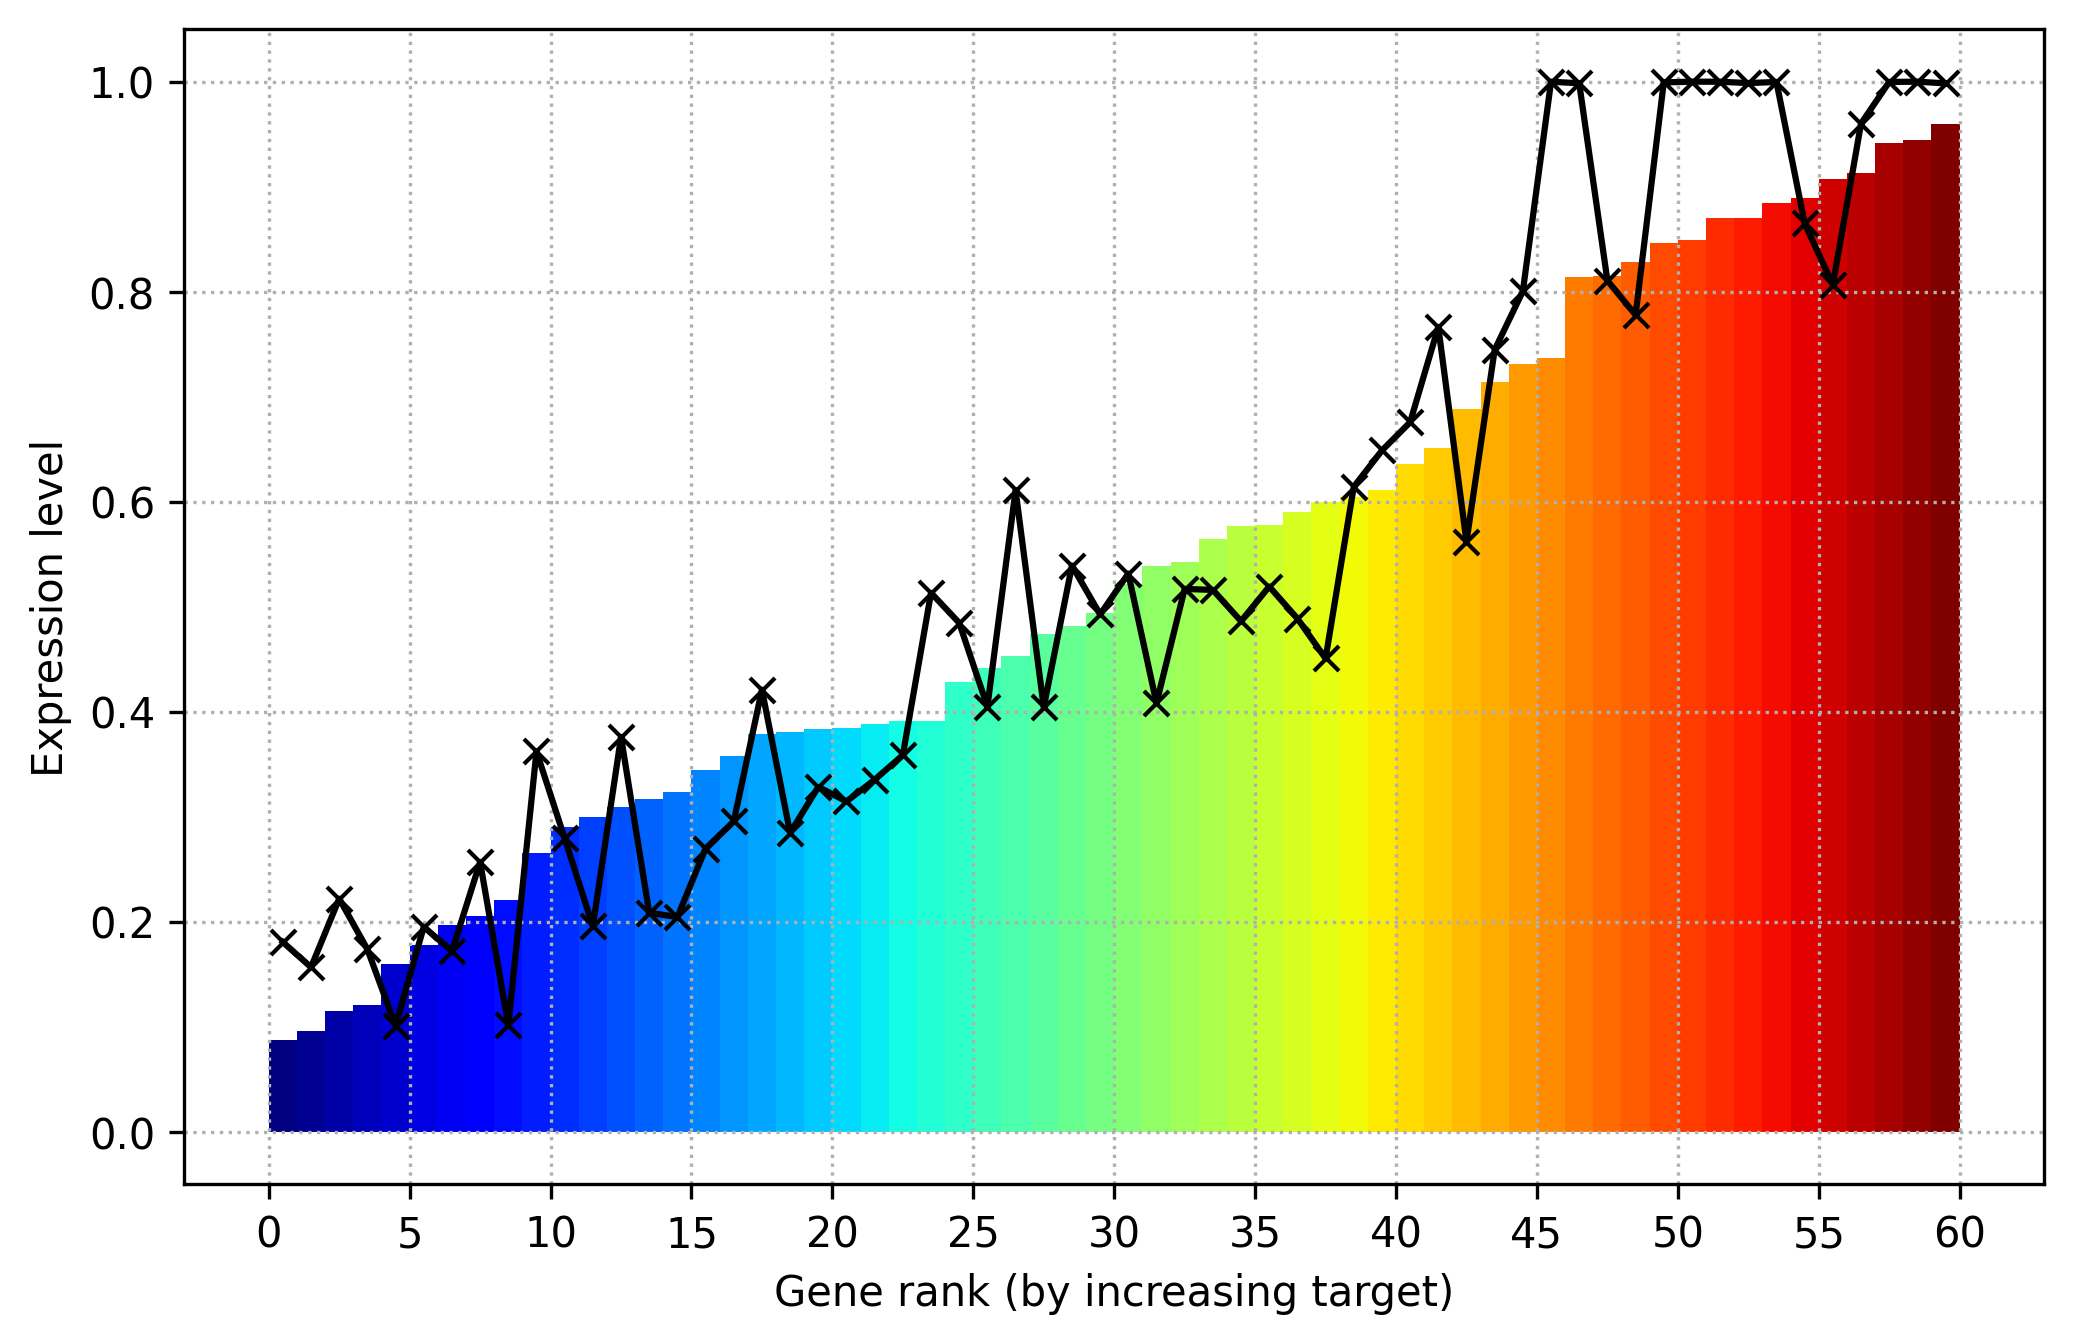

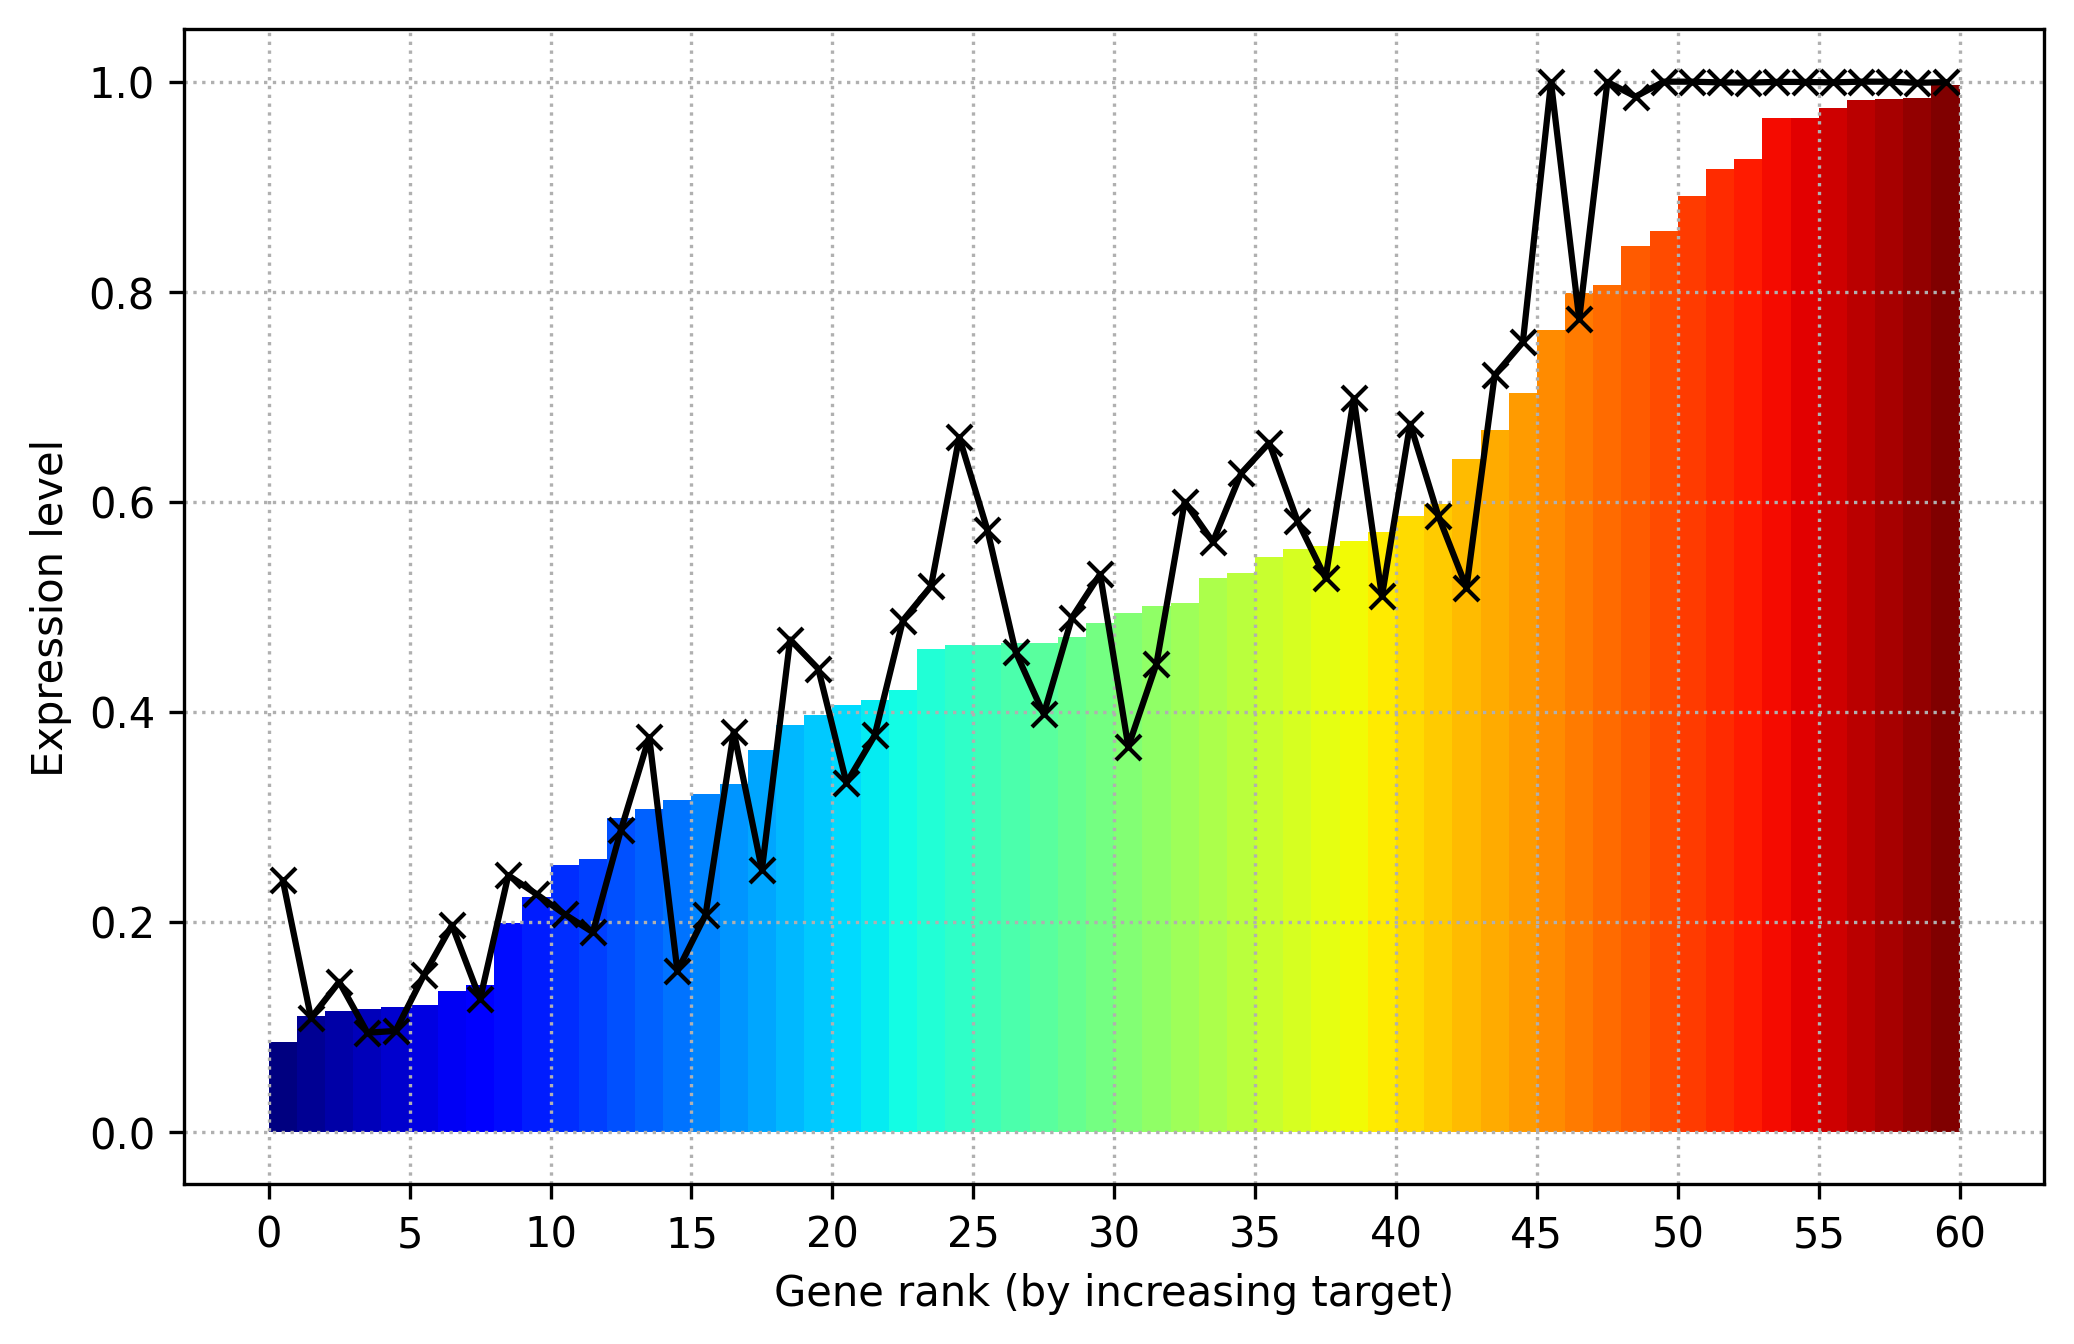

In [69]:
plot_best_indiv(sc_path, sc_params, gen)

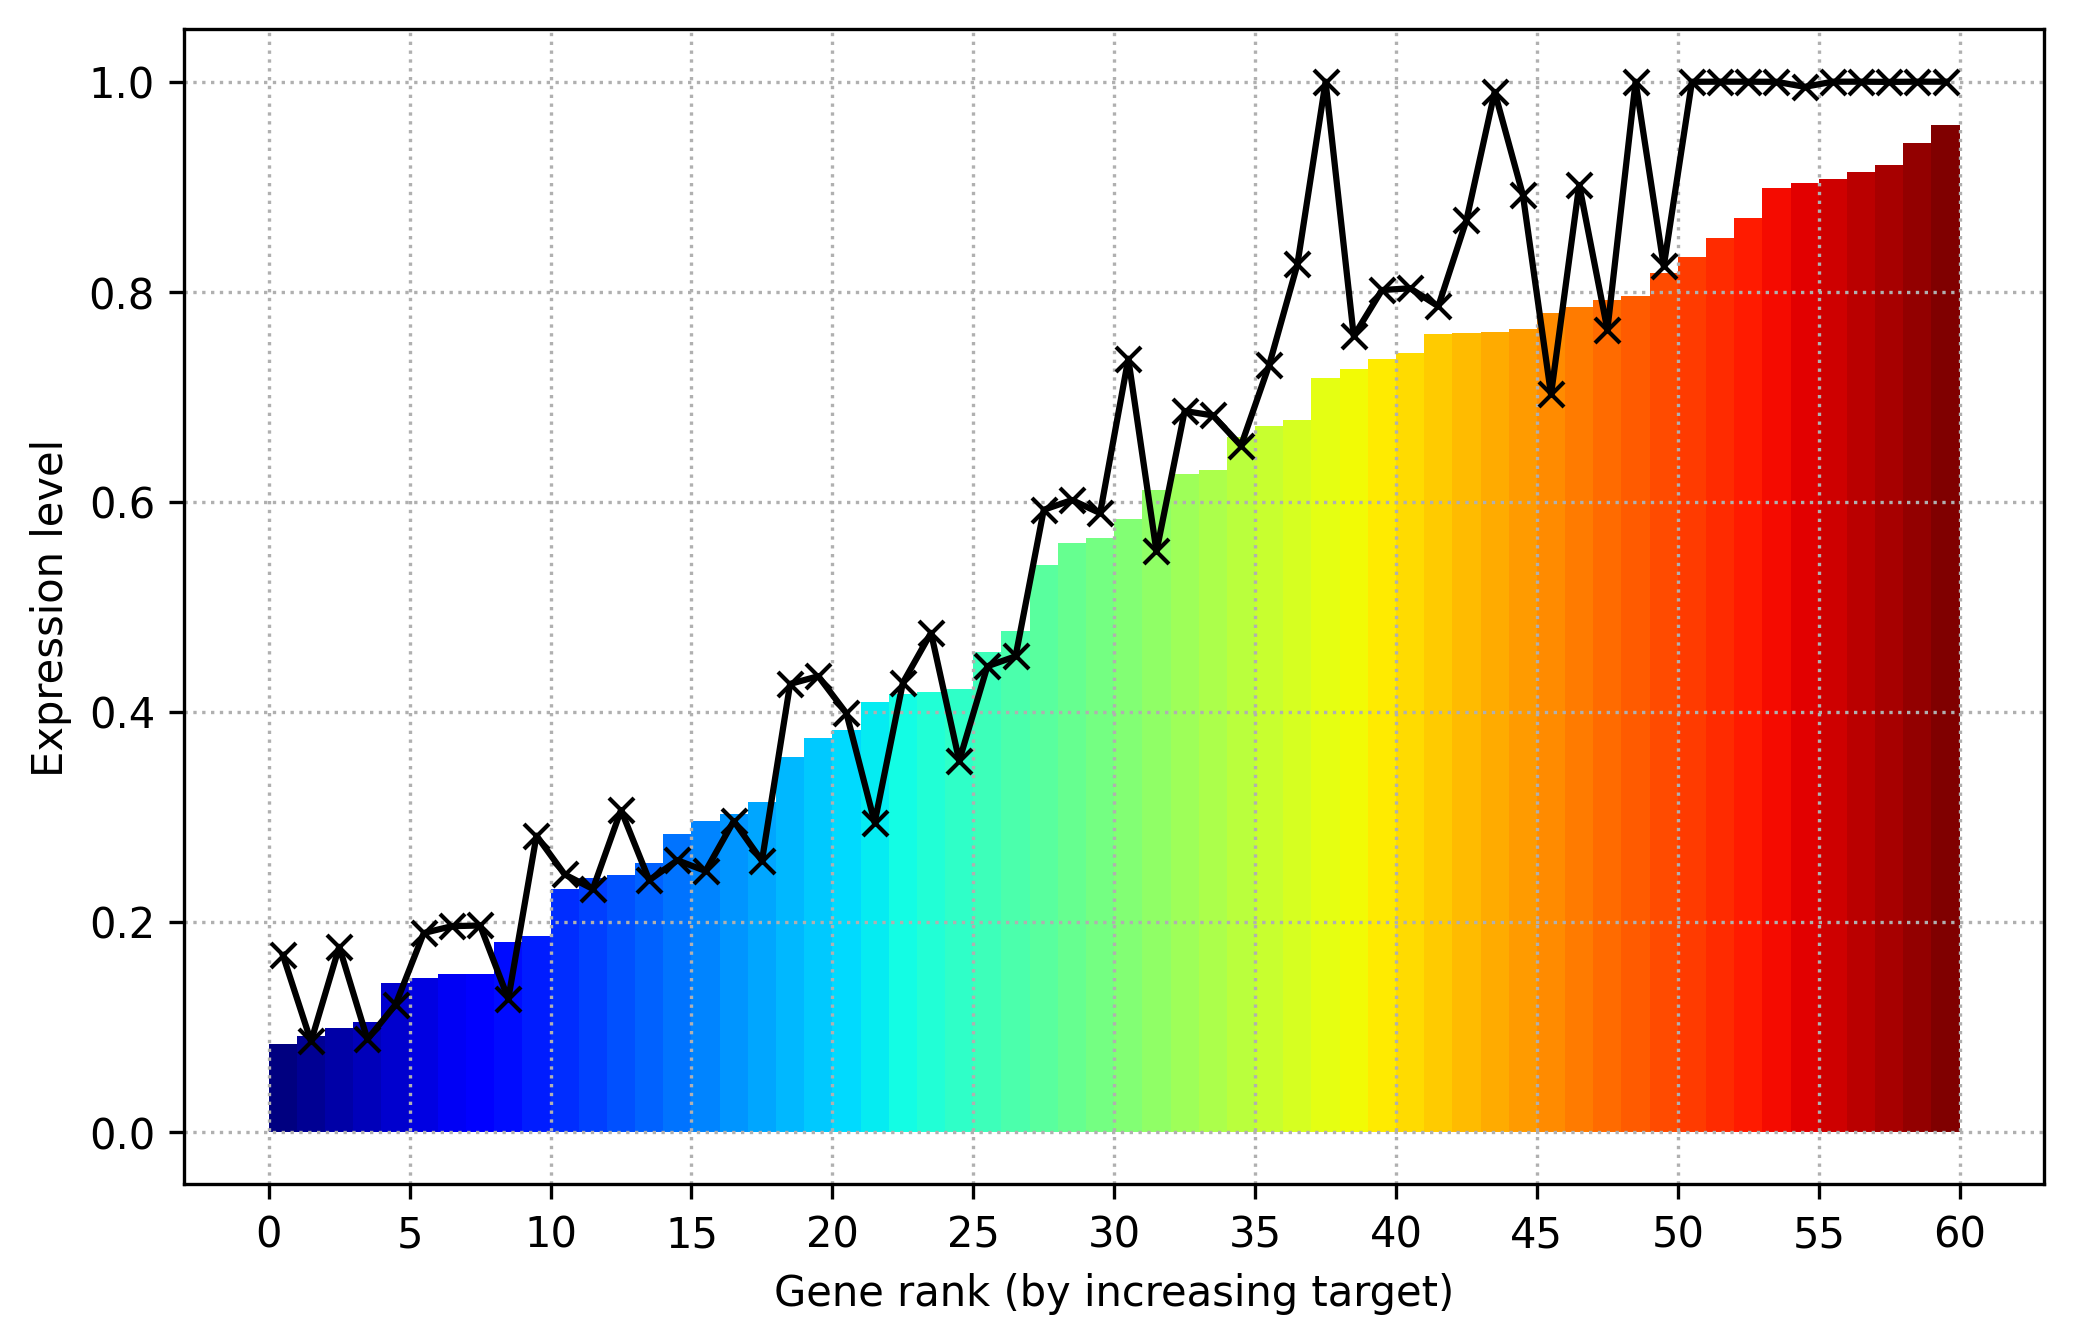

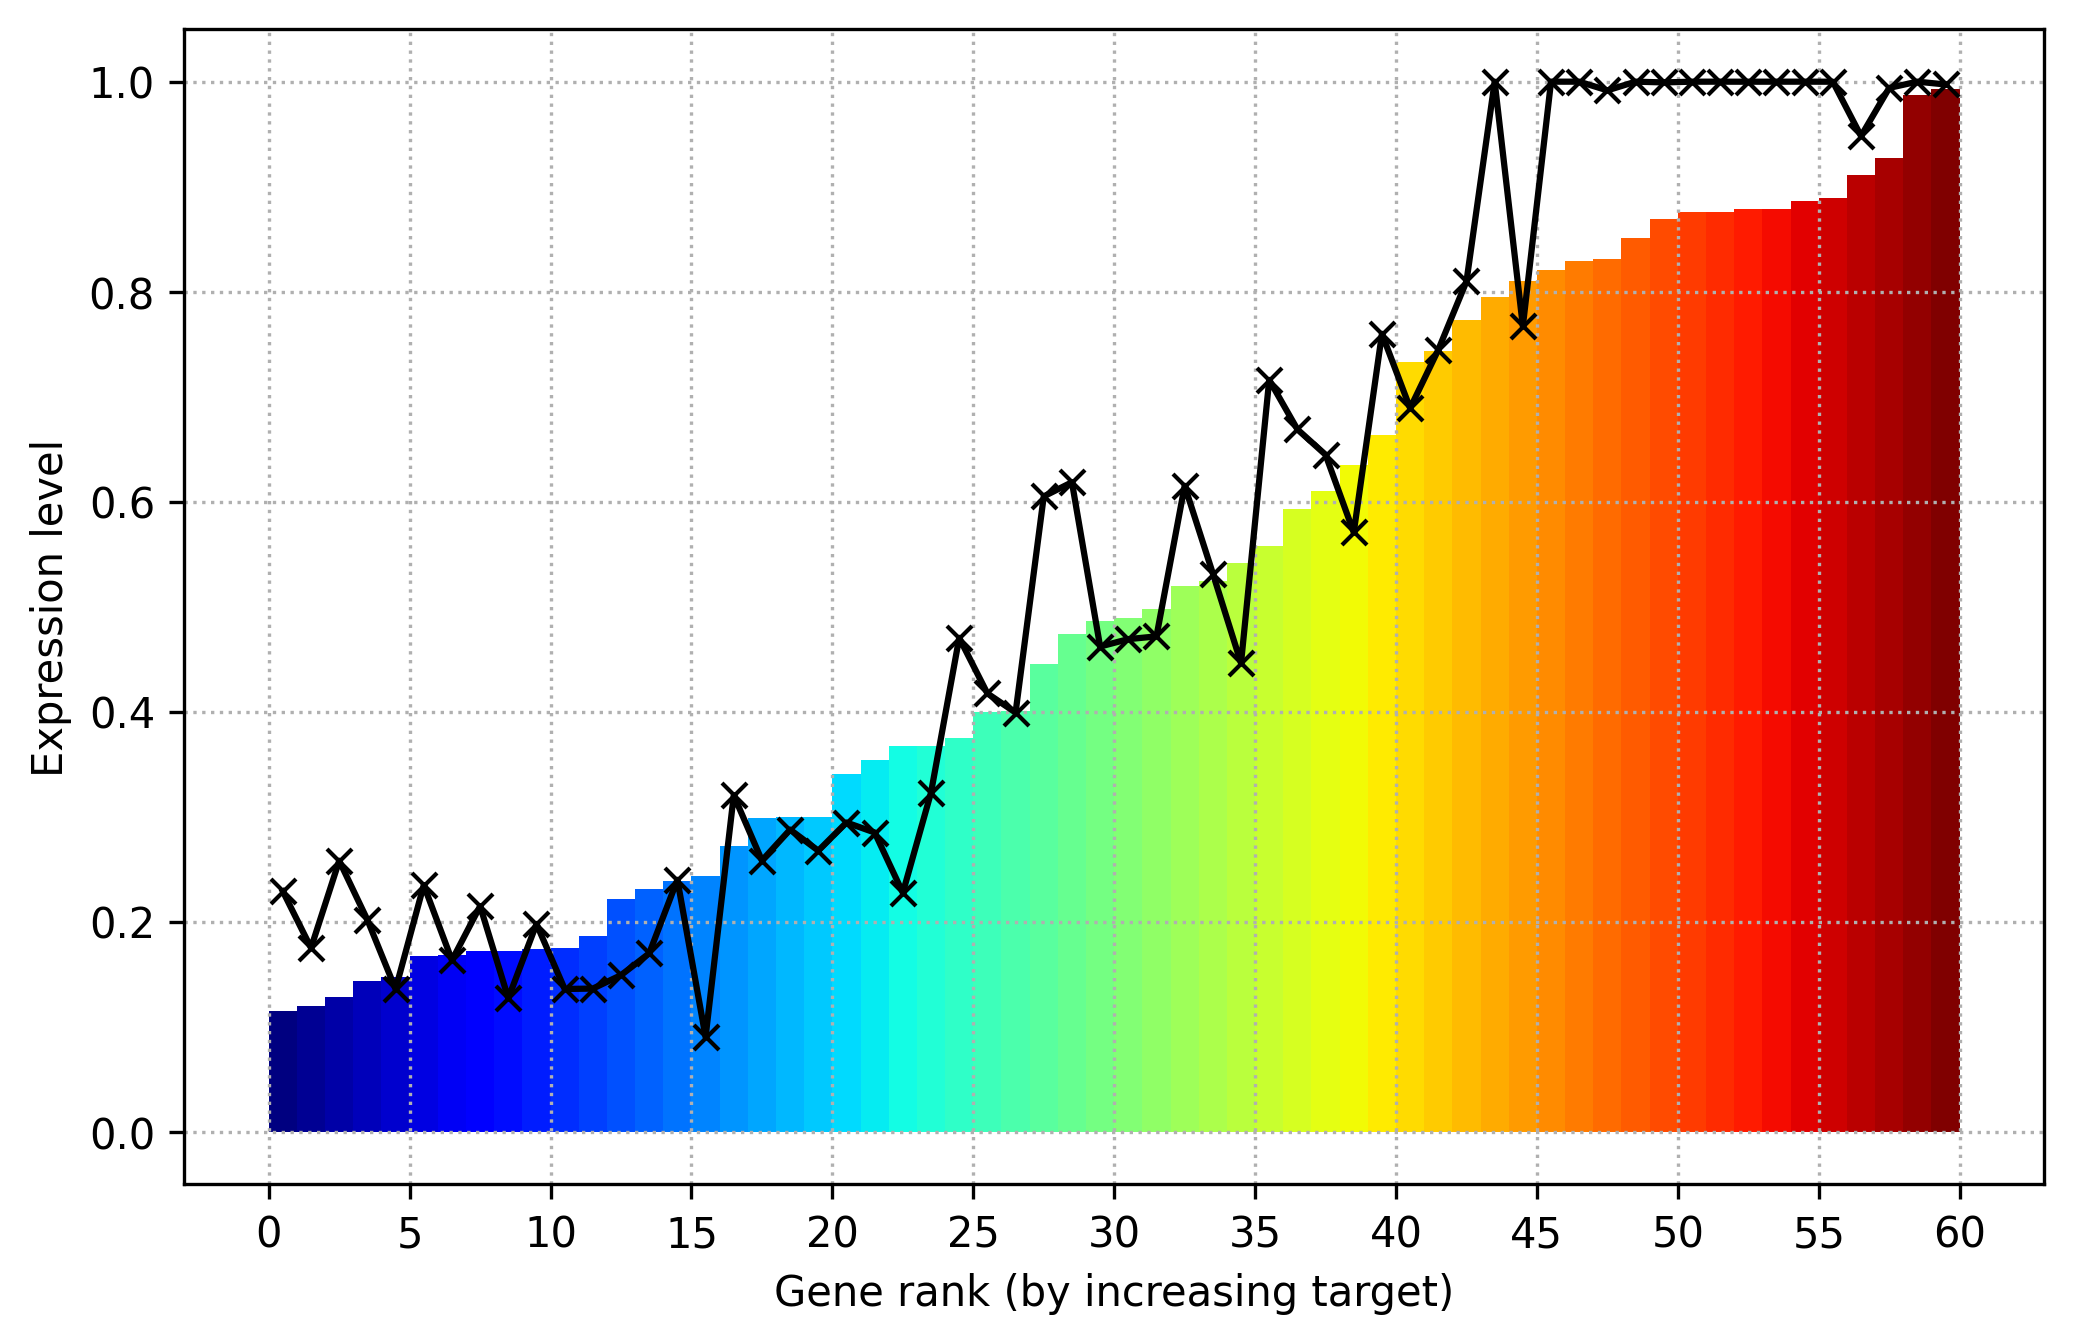

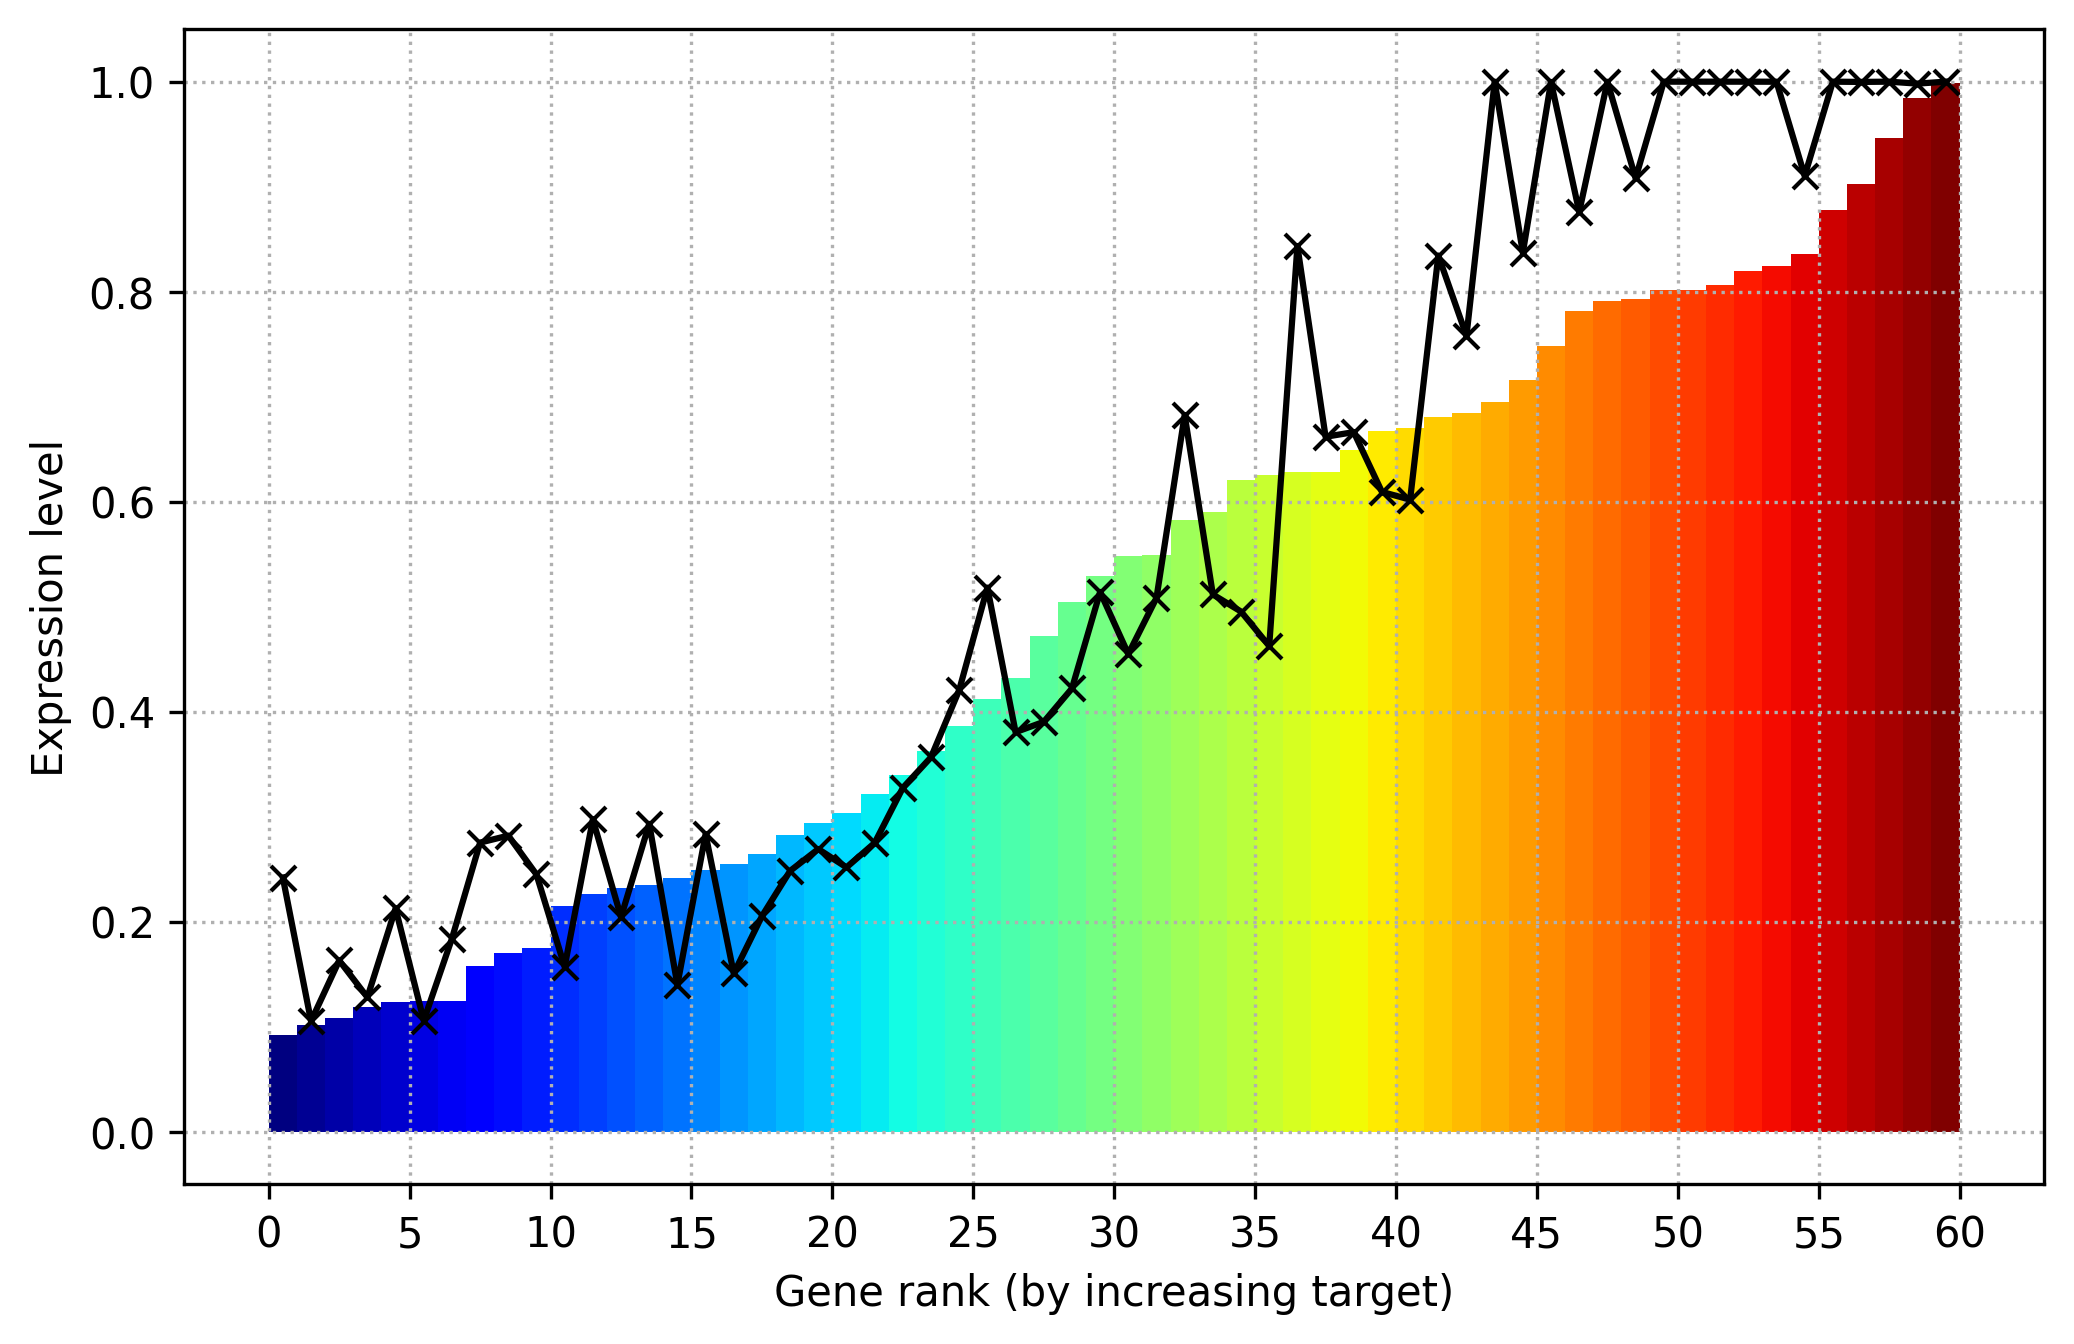

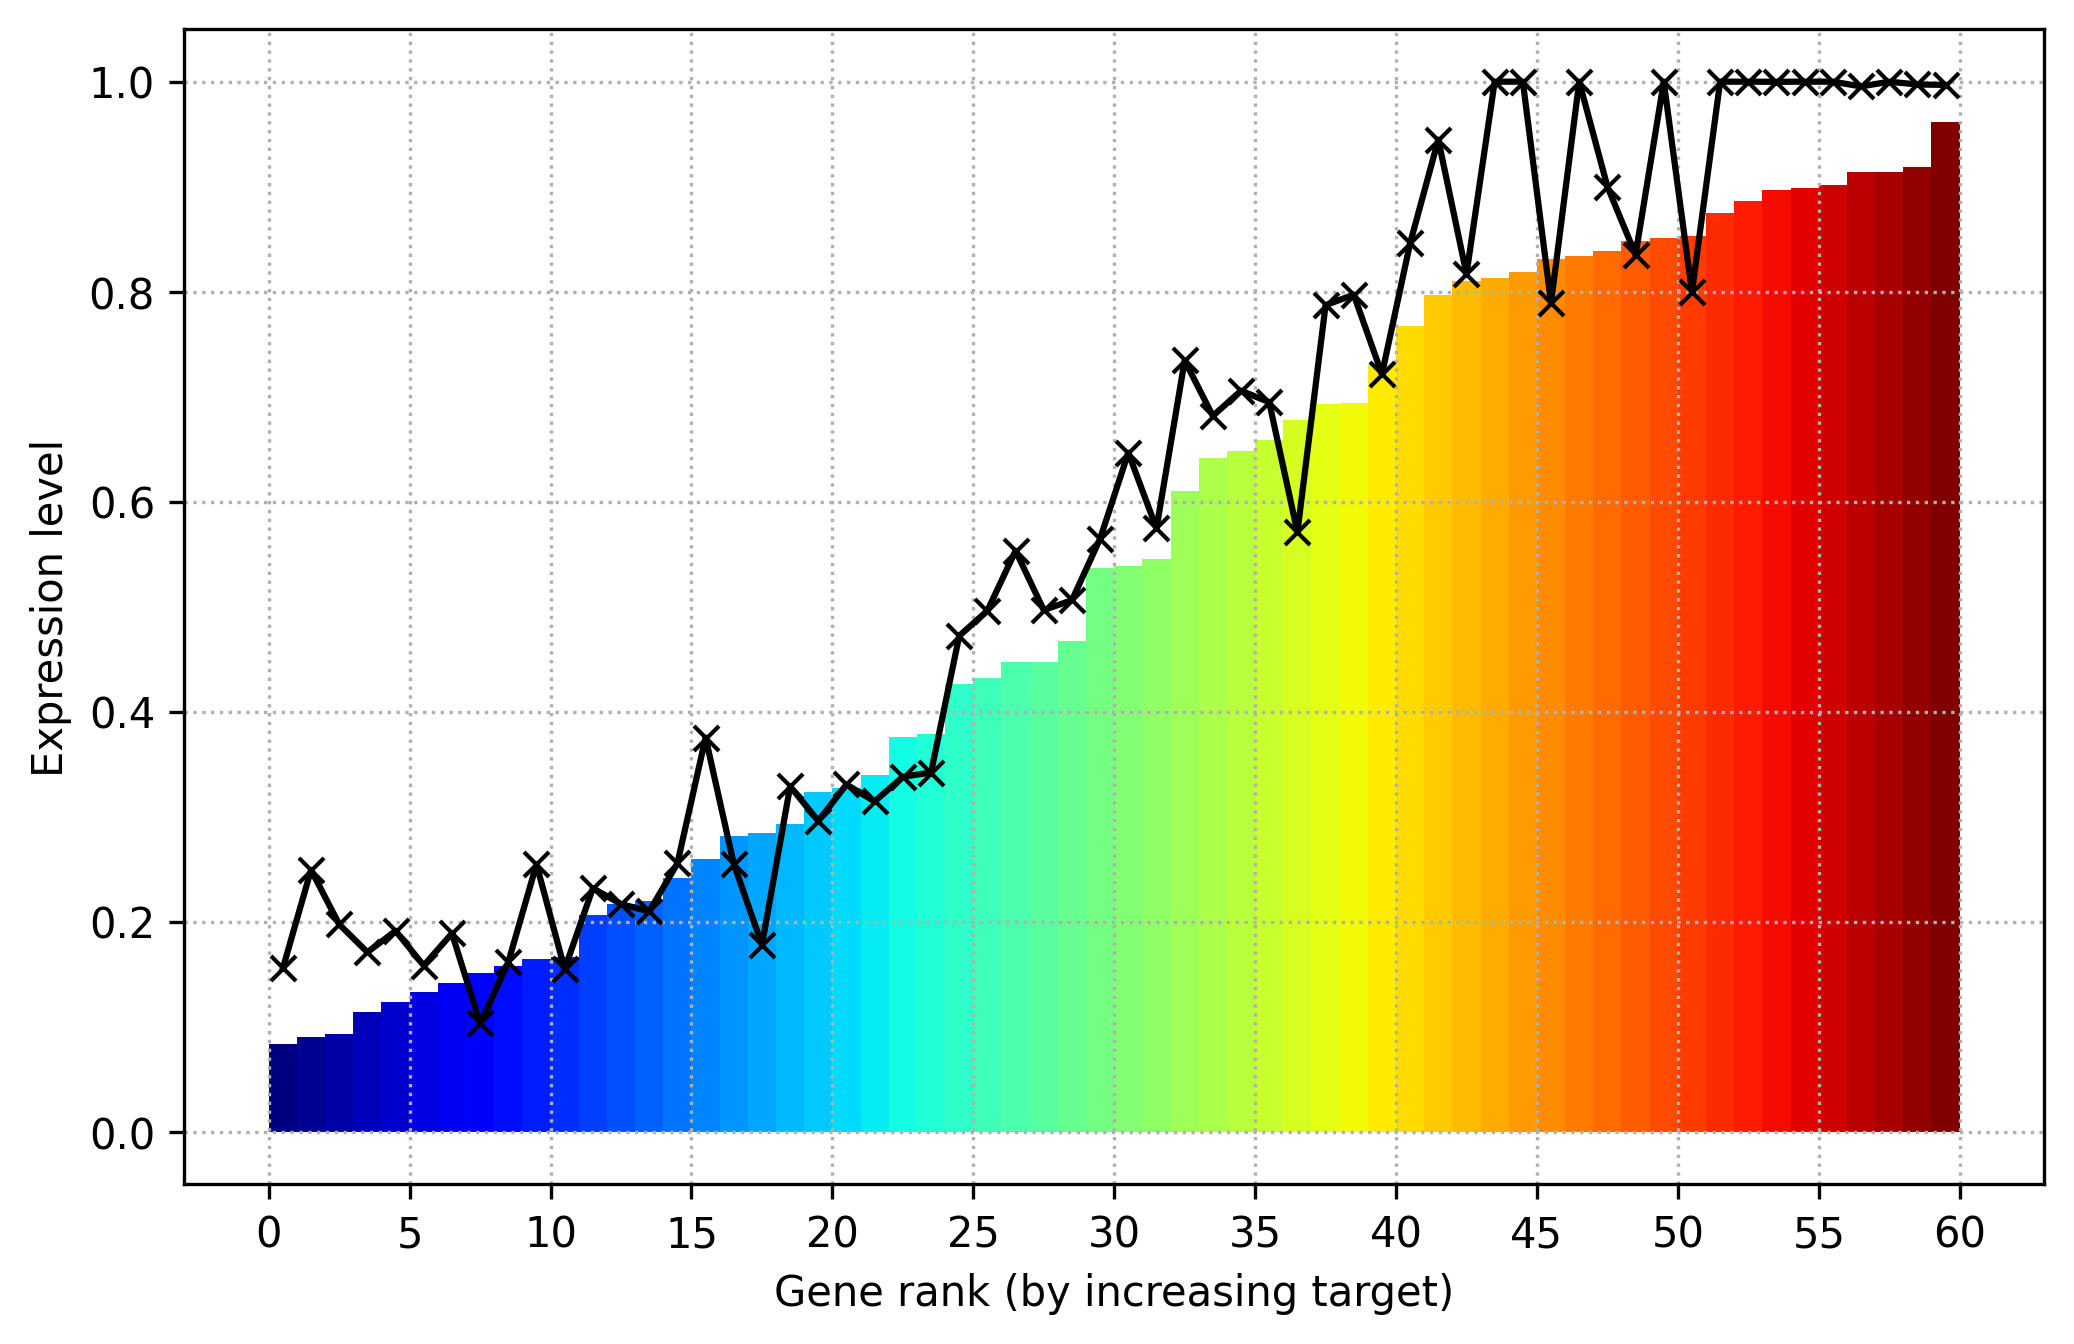

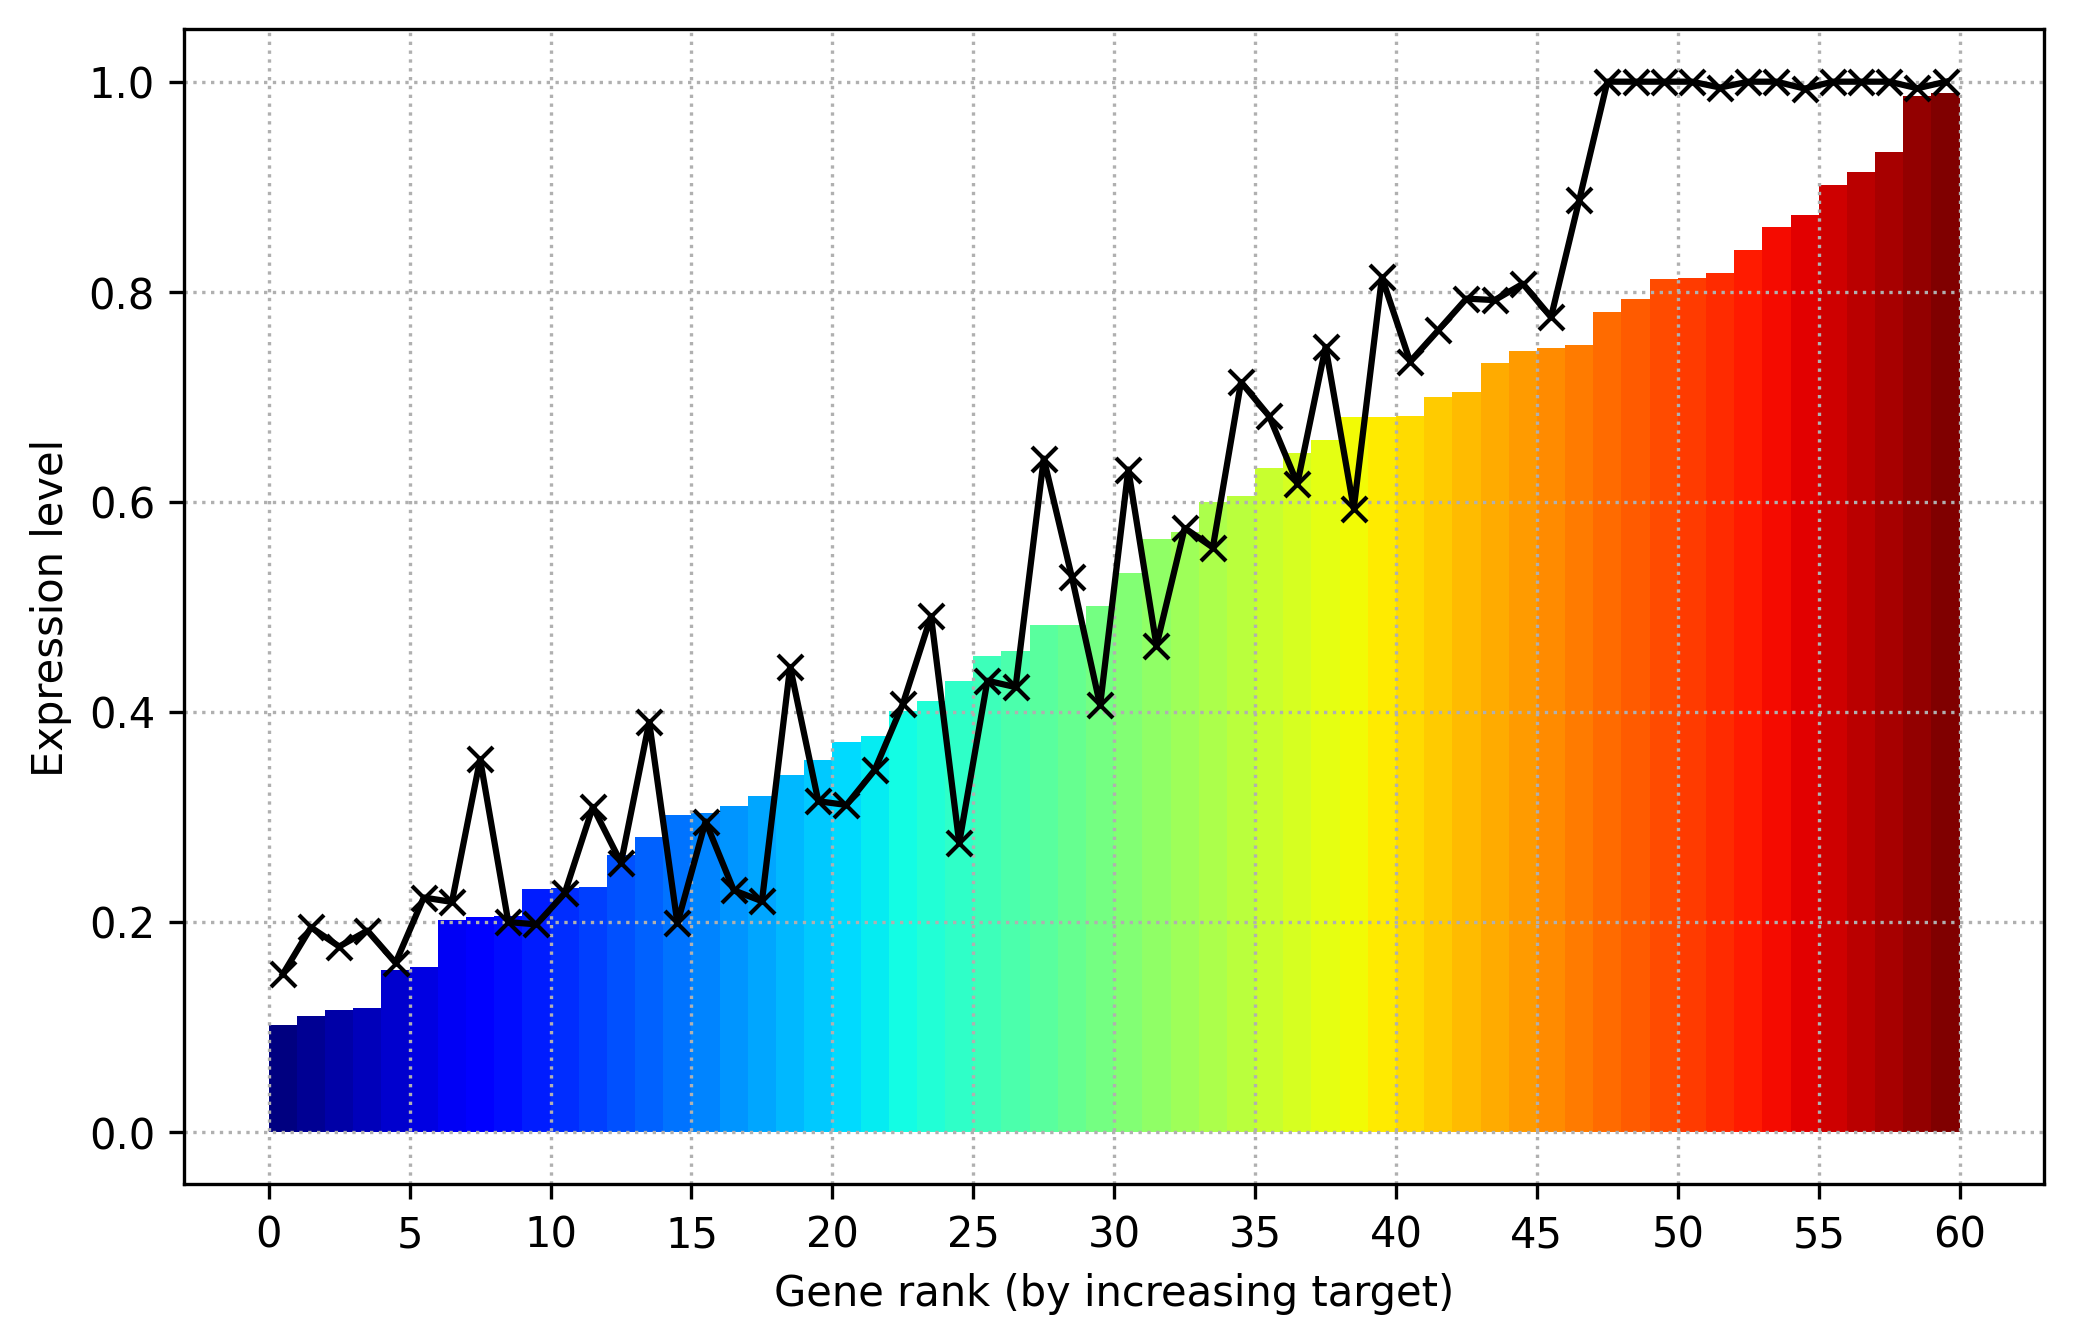

In [70]:
plot_best_indiv(control_path, control_params, gen)

# Plot genomes

In [27]:
def plot_best_genome_and_tsc(exp_path, gen):
    rep_dirs = sorted([d for d in exp_path.iterdir() if (d.is_dir() and d.name.startswith("rep"))])
    
    for rep, rep_dir in enumerate(rep_dirs):
        
        try:
            best_indiv = evotsc_lib.get_best_indiv(rep_dir, gen)
                        
            evotsc_plot.plot_genome_and_tsc(best_indiv, params['sigma_env'], show_bar=True,
                                            coloring_type='by-id',
                                            id_interval=best_indiv.nb_genes / 12, print_ids=True,
                                            plot_name=exp_path.joinpath(f'genome_and_tsc_rep{rep:02}.pdf'))

        except FileNotFoundError: # Skip missing data
            pass

In [28]:
plot_best_genome_and_tsc(exp_path, gen)

NameError: name 'exp_path' is not defined

# Influence of enviromental supercoiling on final gene expression levels

In [ ]:
nb_sigmas = 250
sigma_min = -0.061
sigma_max = 0.061

In [ ]:
def compute_activity_sigma_per_type(indiv, sigmas):
    
    # Initialize the individual
    indiv.evaluate(0.0, 0.0)

    activ = np.zeros((3, len(sigmas))) # Compute activity for each gene type

    for i_sigma, sigma_env in enumerate(sigmas):
        # Evaluate the individual in the environment with sigma
        temporal_expr = indiv.run_system(sigma_env)

        # Compute total gene activation levels        
        for i_gene, gene in enumerate(indiv.genes):
            activ[gene.gene_type][i_sigma] += temporal_expr[-1, i_gene]
            
    activ /= (indiv.nb_genes / 3)
    
    return activ

In [ ]:
def compute_avg_best_activ_by_sigma():
    rep_dirs = sorted([d for d in exp_path.iterdir() if (d.is_dir() and d.name.startswith("rep"))])
    
    sigmas = np.linspace(sigma_min, sigma_max, nb_sigmas)
    activ = np.zeros((3, len(sigmas)))

    for i_rep in range(nb_reps):
        indiv = evotsc_lib.get_best_indiv(exp_path.joinpath(f'rep{i_rep:02}'), gen=gen)
            
        activ += compute_activity_sigma_per_type(indiv, sigmas)
            
    return activ / nb_reps

In [ ]:
#activ = compute_avg_best_activ_by_sigma()

In [ ]:
def generate_rand_activ_by_sigma():

    sigmas = np.linspace(sigma_min, sigma_max, nb_sigmas)
    activ = np.zeros(len(sigmas))  # Average over all genes, not gene types
    
    for i_rand, rand_indiv in enumerate(rand_indivs):
        activ += np.mean(compute_activity_sigma_per_type(rand_indiv, sigmas), axis=0)
        
    return activ / nb_reps

In [ ]:
#rand_activ = generate_rand_activ_by_sigma()

In [ ]:
# See how gene activity levels depend on environmental supercoiling
def plot_activity_sigma_per_type(activ, rand_activ, plot_title=None, plot_name=None):
    
    sigma_basal = params['sigma_basal']
    sigma_opt = params['sigma_opt']      
    
    sigmas_env = np.linspace(sigma_min, sigma_max, nb_sigmas)

    colors = ['tab:blue', 'tab:red', 'tab:green'] # AB: blue, A: red, B: green
    
    fig, ax = plt.subplots(figsize=(7, 4), dpi=dpi)
    
    plt.xlabel('Background supercoiling ($\sigma_{basal} + \delta\sigma_{env}$)')
    plt.ylabel('Average gene expression by type')
    plt.ylim(-0.05, 1.10)
    plt.xlim(sigmas_env[0] + sigma_basal, sigmas_env[-1] + sigma_basal)
    plt.grid(linestyle=':')
    
    # Add 1/2 expression level
    half_expr = (1 + np.exp(- params['m'])) / 2
    plt.hlines(half_expr, sigmas_env[0] + sigma_basal, sigmas_env[-1] + sigma_basal,
               linestyle=':', linewidth=1.5, color='tab:pink')#, label='Activation threshold')
    
    
    # Add average expression per gene type
    for i_gene_type, gene_type in enumerate(gene_types):
        plt.plot(sigmas_env + sigma_basal, activ[i_gene_type, :],
                 color=gene_type_color[i_gene_type],
                 linewidth=2,
                 label=gene_type)

    # Add sigma_A and sigma_B
    y_min, y_max = plt.ylim()
    plt.vlines(params['sigma_A'] + sigma_basal, y_min, y_max, linestyle='--', linewidth=1, color='black')
    plt.vlines(params['sigma_B'] + sigma_basal, y_min, y_max, linestyle='--', linewidth=1, color='black')
    
    plt.text(params['sigma_A'] + sigma_basal, y_max + 0.005, '$\sigma_A$',
             va='bottom', ha='center', fontsize='large') # Use \mathbf{} for bold
    plt.text(params['sigma_B'] + sigma_basal, y_max + 0.005, '$\sigma_B$',
             va='bottom', ha='center', fontsize='large')
    plt.ylim(y_min, y_max)
    
    # Add expression for a random genome
    plt.plot(sigmas_env + sigma_basal, rand_activ,
         linewidth=2, color='tab:cyan', zorder=0, linestyle=(0, (3, 1, 1, 1)), label='Random')
    
    # Add expression for an isolated gene
    sigmas_total = sigmas_env + sigma_basal
    activities = 1.0 / (1.0 + np.exp((sigmas_total - sigma_opt)/ params['epsilon']))
    plt.plot(sigmas_env + sigma_basal, np.exp(params['m'] * (activities - 1)),
             linewidth=2, color='tab:cyan', zorder=0, linestyle='--', label='Isolated gene')

    plt.legend(loc='lower left')
    
    # Add other ax with other sc
    ax2 = ax.twiny()
    xmin, xmax = ax.get_xlim()
    ax2.set_xlim(xmin - params['sigma_basal'], xmax - params['sigma_basal'])
    ax2.set_xlabel('Environmental shift in supercoiling ($\delta\sigma_{env}$)')
    
    # Wrap up            
    if plot_name:
        plt.savefig(plot_name, dpi=dpi, bbox_inches='tight')
        
    plt.show()
    plt.close()

In [ ]:
#plot_activity_sigma_per_type(activ, rand_activ,
#                             plot_name=exp_path.joinpath(f'activity_sigmas_avg.pdf'))

# Gene knockouts

## Arrange Individual and run_system() to accommodate a knocked-out gene

In [ ]:
@jit(nopython=True)
def run_system_numba_ko(nb_genes: int,
                        init_expr: np.ndarray,
                        inter_matrix: np.ndarray,
                        sigma_basal: float,
                        sigma_opt: float,
                        epsilon: float,
                        m: float,
                        sigma_env: float,
                        id_ko: int) -> np.ndarray:

    step_size = 0.5
    stop_dist = 1e-7
    max_eval_steps = 200

    temporal_expr = np.zeros((max_eval_steps+1, nb_genes))

    # Initial values at t = 0
    temporal_expr[0, :] = init_expr
    temporal_expr[0, id_ko] = 0.0


    # Iterate the system
    it = 1
    cont = True
    while cont:
        prev_expr = temporal_expr[it-1, :]
        sigma_local = inter_matrix @ prev_expr
        sigma_total = sigma_basal + sigma_local + sigma_env

        promoter_activity = 1.0 / (1.0 + np.exp((sigma_total - sigma_opt)/epsilon))

        # We subtract 1 to rescale between exp(-m) and 1
        iter_expr = np.exp(m * (promoter_activity - 1.0))

        nouv_expr = step_size * iter_expr + (1 - step_size) * prev_expr

        # Knockout
        nouv_expr[id_ko] = 0

        temporal_expr[it, :] = nouv_expr

        # Check if we're done
        dist = np.abs(nouv_expr - prev_expr).sum() / nb_genes

        prev_expr = nouv_expr

        if dist < stop_dist:
            cont = False

        if it == max_eval_steps:
            cont = False
        it += 1

    temporal_expr = temporal_expr[:it, :]

    return temporal_expr

In [ ]:
class KoIndividual(evotsc.Individual):
    def __init__(self,
                 orig_indiv: evotsc.Individual,
                 id_ko: int) -> None:
        
        super().__init__([gene.clone() for gene in orig_indiv.genes],
                         orig_indiv.interaction_dist,
                         orig_indiv.interaction_coef,
                         orig_indiv.sigma_basal,
                         orig_indiv.sigma_opt,
                         orig_indiv.epsilon,
                         orig_indiv.m,
                         orig_indiv.selection_coef,
                         orig_indiv.rng)
        
        self.id_ko = id_ko
                    

    def run_system(self, sigma_env):

        init_expr = np.array([gene.basal_expression for gene in self.genes])

        self.inter_matrix = self.compute_inter_matrix()

        return run_system_numba_ko(nb_genes=self.nb_genes,
                                   init_expr=init_expr,
                                   inter_matrix=self.inter_matrix,
                                   sigma_basal=self.sigma_basal,
                                   sigma_opt=self.sigma_opt,
                                   epsilon=self.epsilon,
                                   m=self.m,
                                   sigma_env=sigma_env,
                                   id_ko=self.id_ko)

## Plot genome and TSC with one knocked-out gene

In [ ]:
def plot_all_kos(rep, gen):
    
    rep_dir = exp_path.joinpath(f'rep{rep}')
    
    ko_path = exp_path.joinpath(f'kos_rep{rep:02}')
    ko_path.mkdir(exist_ok=True)
    
    init_indiv = evotsc_lib.get_best_indiv(rep_dir, gen=gen)
    n = 100  # the number of data points
    _, genome_length = init_indiv.compute_gene_positions(include_coding=True)
    data_positions = np.linspace(0, genome_length, n, dtype=int)

    # Note: we do the difference between the supercoiling values of two genomes of the same individual,
    # so sigma_basal and sigma_env cancel out
    init_data = {'A': init_indiv.compute_final_sc_at(params['sigma_A'], data_positions),
                 'B': init_indiv.compute_final_sc_at(params['sigma_B'], data_positions)}
    
    init_expr = {'A': init_indiv.run_system(params['sigma_A'])[-1, :],
                 'B': init_indiv.run_system(params['sigma_B'])[-1, :]}
    
    
    half_expr = (1 + np.exp(-init_indiv.m)) / 2
    init_activ = {env: init_expr[env] > half_expr for env in envs}
    
    for i_ko in range(36, 37): 
    #for i_ko in range(init_indiv.nb_genes):
        
        ko_indiv = KoIndividual(orig_indiv=init_indiv, id_ko=i_ko)
                                            
        for env in envs:
                                            
            ko_data = ko_indiv.compute_final_sc_at(params[f'sigma_{env}'], data_positions)
            
            final_expr = ko_indiv.run_system(params[f'sigma_{env}'])[-1, :]
            ko_activ = final_expr > half_expr
            
            switched_genes = init_activ[env] != ko_activ
            
            show_bar = env == 'A'
            
            plot_name = ko_path.joinpath(f'ko_genome_and_tsc_env_{env}_gene_{i_ko:02}.pdf')
            
            evotsc_plot.plot_genome_and_tsc(ko_indiv, sigma=params[f'sigma_{env}'], coloring_type='on-off',
                                            hatched_genes=switched_genes,
                                            print_ids=True, ring_data=np.abs(init_data[env]-ko_data), 
                                            ring_color_type='delta', 
                                            show_bar=show_bar, bar_text='$|\Delta\sigma_{TSC}|$',
                                            id_interval=5, id_ko=i_ko,
                                            plot_name=plot_name)

In [ ]:
if figure_rep < nb_reps:
    plot_all_kos(rep=figure_rep, gen=gen)

## Compute the effective graph: genes switched on or off by a KO

In [ ]:
def get_effective_graph(best_indiv, sigma):
    
    _, genome_length = best_indiv.compute_gene_positions(include_coding=True)
    
    init_expr = best_indiv.run_system(sigma)[-1, :]
    half_expr = (1 + np.exp(-best_indiv.m)) / 2
    init_activ = init_expr > half_expr
    

    ## Build the graph
    inter_graph = nx.DiGraph()

    # Nodes
    for i_gene, gene in enumerate(best_indiv.genes):
        inter_graph.add_node(i_gene, gene=gene)

    ## Compute the interactions: if KOing gene A switches gene B on or off, add A -> B arrow to the graph

    for i_ko in range(best_indiv.nb_genes):
        
        ko_indiv = KoIndividual(orig_indiv=best_indiv, id_ko=i_ko)
                                                                    
        final_expr = ko_indiv.run_system(sigma)[-1, :]
        ko_activ = final_expr > half_expr
        
        for i_other in range(best_indiv.nb_genes):
            if i_other == i_ko:
                continue
            
            if init_activ[i_other] != ko_activ[i_other]:
                if init_activ[i_other]: # KOing i_ko inhibits i_other: -> i_ko activates i_other
                    inter_graph.add_edge(i_ko, i_other, kind='activ')
                else:
                    inter_graph.add_edge(i_ko, i_other, kind='inhib')

    return best_indiv, inter_graph

In [ ]:
def get_all_effective_graphs(exp_path, gen):
    rep_dirs = sorted([d for d in exp_path.iterdir() if (d.is_dir() and d.name.startswith("rep"))])
    
    graphs = {}
    
    for rep, rep_dir in enumerate(rep_dirs):
        best_indiv = evotsc_lib.get_best_indiv(rep_path=rep_dir, gen=gen)

        graphs[rep] = get_effective_graph(best_indiv, params['sigma_env'])
    
    return graphs

In [ ]:
effective_graphs = get_all_effective_graphs(exp_path, gen)

## Plot the effective graphs

In [ ]:
def plot_effective_graph(indiv, inter_graph, method, plot_name=None):
    
    colors = mpl.cm.get_cmap('viridis', indiv.nb_genes)(range(indiv.nb_genes))

    
    ## Draw the figure
    plt.figure(figsize=(12, 12), dpi=dpi)
    plt.box(False)

    # Choose the layout
    if method == 'circular':
        layout = nx.circular_layout(inter_graph)
        for node in layout:
            x, y = layout[node]
            layout[node] = y, x # symmetry along the y=x axis to match other graphs

    elif method == 'graphviz':
        layout = nx.nx_agraph.graphviz_layout(inter_graph)
        for node in layout:
            x, y = layout[node]
            layout[node] = -x, -y # 180 degree rotation


    # Draw the nodes
    node_size = 400
    nx.draw_networkx_nodes(inter_graph, layout, node_size=node_size,
                           node_color=[colors[gene.id] for gene in indiv.genes])
    nx.draw_networkx_labels(inter_graph, layout)

    # Draw the edges
    activ_edges = [e for e in inter_graph.edges if inter_graph[e[0]][e[1]]['kind'] == 'activ'] 
    inhib_edges = [e for e in inter_graph.edges if inter_graph[e[0]][e[1]]['kind'] == 'inhib']

    inhib_arrow = mpl.patches.ArrowStyle.CurveFilledB(head_length=0, head_width=0.5)

    nx.draw_networkx_edges(inter_graph, layout, edgelist=activ_edges, node_size=node_size,
                           edge_color='tab:green', connectionstyle='arc3,rad=0.1')
    nx.draw_networkx_edges(inter_graph, layout, edgelist=inhib_edges, node_size=node_size+75,
                           arrowstyle=inhib_arrow, edge_color='tab:red',
                           connectionstyle='arc3,rad=0.1')

    if plot_name:
        plt.savefig(plot_name, bbox_inches='tight', dpi=dpi)
    plt.show()
    plt.close()

In [ ]:
def plot_combined_effective_graphs(effective_graphs, method, is_random=False):
    graph_path = exp_path.joinpath(f'effective_graphs')
    graph_path.mkdir(exist_ok=True)
    
    for rep in effective_graphs.keys():
        indiv, graph = effective_graphs[rep]
        
        
        plot_name = f'combined_effective_graph_rep{rep:02}_{method}.pdf'
        if is_random:
            plot_name = f'rand_{plot_name}'

        full_name = graph_path.joinpath(plot_name)
        
        plot_effective_graph(indiv, graph, method, full_name)

In [ ]:
plot_combined_effective_graphs(effective_graphs,
                                   'graphviz', is_random=False)

## Make random individuals for comparison

In [ ]:
def make_random_effective_graphs():
    
    graphs = {rep: {} for rep in range(nb_reps)}
        
    for i_rep, rand_indiv in enumerate(rand_indivs):        

        graphs[i_rep] = get_effective_graph(rand_indivs[i_rep], params[f'sigma_env'])
    
    return graphs

In [ ]:
rand_effective_graphs = make_random_effective_graphs()

In [ ]:
#plot_combined_effective_graphs(rand_effective_graphs, 'graphviz', is_random=True)

## Connected components

In [ ]:
def count_largest_wcc(effective_graphs):
    
    largest_wcc = np.zeros(len(effective_graphs))
    
    for rep in list(effective_graphs.keys()):
        indiv, graph = effective_graphs[rep]
        
        largest_wcc[rep] = len(max(nx.weakly_connected_components(graph), key=len))
        
    return largest_wcc

In [ ]:
def gather_all_wccs(effective_graphs):
    wccs = []
    
    for rep in list(effective_graphs.keys()):
        indiv, graph = effective_graphs[rep]
        
        for wcc in nx.weakly_connected_components(graph):
            wccs.append(len(wcc))
                
    return np.array(wccs)

In [ ]:
def plot_all_wccs(effective_graphs, rand_effective_graphs):

    evolved_wccs = gather_all_wccs(effective_graphs)

    rand_wccs = gather_all_wccs(rand_effective_graphs)

    plt.figure(figsize=(3, 7), dpi=dpi)
    plt.boxplot([evolved_wccs, rand_wccs],
                #showmeans=True,
                #meanprops={'marker':'_', 'markerfacecolor':'black', 'markeredgecolor':'black'},
                medianprops={'color':'black'})
    plt.xticks(ticks=[1, 2], labels=['Evolved', 'Random'])
    plt.ylim(-3, 63)
    plt.ylabel('Number of genes in the WCC')
    plt.grid(linestyle=':', axis='y')
    plt.savefig(exp_path.joinpath('effective_graph_wcc_distr.pdf'), bbox_inches='tight', dpi=dpi)
    plt.show()

In [ ]:
plot_all_wccs(effective_graphs, rand_effective_graphs)

### Show the exact count for every WCC size

In [ ]:
np.unique(gather_all_wccs(effective_graphs), return_counts=True)

## Stats on the effective graphs: out degree (number of switches)

In [ ]:
def dist_in_genes(nb_genes, i, j):
    pos_1_minus_2 = i - j
    pos_2_minus_1 = - pos_1_minus_2

    # We want to know whether gene 1 comes before or after gene 2
    # Before: -------1--2-------- or -2---------------1-
    # After:  -------2--1-------- or -1---------------2-

    if pos_1_minus_2 < 0: # -------1--2-------- ou -1---------------2-
        if pos_2_minus_1 < nb_genes + pos_1_minus_2: # -------1--2--------
            distance = pos_2_minus_1
        else: # -1---------------2-
            distance = nb_genes + pos_1_minus_2

    else: # -------2--1-------- ou -2---------------1-
        if pos_1_minus_2 < nb_genes + pos_2_minus_1: # -------2--1--------
            distance = pos_1_minus_2
        else:
            distance = nb_genes + pos_2_minus_1

    return distance

In [ ]:
def get_effective_graph_stats(effective_graphs):
    res_dict = {'Replicate': [],
                'out_deg': [],
                'avg_dist': [],
                'max_dist': []}

    for rep in effective_graphs.keys():
        indiv, graph = effective_graphs[rep]
        for i_gene, gene in enumerate(indiv.genes):
            res_dict['Replicate'].append(rep)
            res_dict['out_deg'].append(graph.out_degree[i_gene])

            if graph.out_degree[i_gene] > 0:
                dists = np.zeros(len(graph[i_gene].keys()), dtype=int)                
                for i_neighbor, neighbor in enumerate(graph[i_gene].keys()):
                    dists[i_neighbor] = dist_in_genes(indiv.nb_genes, i_gene, neighbor)

                res_dict['avg_dist'].append(np.mean(dists))
                res_dict['max_dist'].append(np.max(dists))

            else:
                res_dict['avg_dist'].append(0)
                res_dict['max_dist'].append(0)

    return pd.DataFrame.from_dict(res_dict)

In [ ]:
graph_stats = get_effective_graph_stats(effective_graphs)

In [ ]:
rand_graph_stats = get_effective_graph_stats(rand_effective_graphs)

In [ ]:
def get_combined_graph_stats(effective_graphs):
    res_dict = {'Replicate': [],
                'out_deg': [],
                'in_deg': [],
                'avg_dist': [],
                'max_dist': []}

    for rep in effective_graphs.keys():

        indiv, graph = effective_graphs[rep]
        
        for i_gene, gene in enumerate(indiv.genes):
            res_dict['Replicate'].append(rep)
            res_dict['out_deg'].append(graph.out_degree[i_gene])
            res_dict['in_deg'].append(graph.in_degree[i_gene])

            if graph.out_degree[i_gene] > 0:
                dists = np.zeros(len(graph[i_gene].keys()), dtype=int)                
                for i_neighbor, neighbor in enumerate(graph[i_gene].keys()):
                    dists[i_neighbor] = dist_in_genes(indiv.nb_genes, i_gene, neighbor)

                res_dict['avg_dist'].append(np.mean(dists))
                res_dict['max_dist'].append(np.max(dists))

            else:
                res_dict['avg_dist'].append(0)
                res_dict['max_dist'].append(0)
                
    return pd.DataFrame.from_dict(res_dict)

In [ ]:
combined_stats = get_combined_graph_stats(effective_graphs)

In [ ]:
combined_rand_stats = get_combined_graph_stats(rand_effective_graphs)